In [25]:
#matplotlib libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns
import numpy as np
#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [18]:
df = pd.read_csv('/Users/mac/Downloads/train.csv')
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE   0.00            0
1   1  2013-01-01          1   BABY CARE   0.00            0
2   2  2013-01-01          1      BEAUTY   0.00            0
3   3  2013-01-01          1   BEVERAGES   0.00            0
4   4  2013-01-01          1       BOOKS   0.00            0

In [19]:
df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [21]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [22]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.drop('LIQUOR,WINE,BEER',axis='columns',inplace=True)
total_sales_df.head()

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   

family      LAWN AND GARDEN  LINGERIE  MAGAZINES    MEATS  PERSONAL CARE  \
date                                                                       
2013-01-01             2.00      5.00       0.00   110.80          25.00   
2013-01-02           121.00    469.00       0.00 20871.46       17204.00   
2013-01-03            83.00    366.00       0.00 16597.40       12568.00   
2013-01-04           127.00    382.00       0.00 21625.96       11303.00   
2013-01-05           180.00    458.00       0.00 20879.09       16819.00   

family      PET SUPPLIES  PLAYERS AND ELECTRONICS  POULTRY  PREPARED FOODS  \
date                                                                         
2013-01-01          0.00                     0.00    42.64           37.85   
2013-01-02          0.00                     0.00 13975.88         5338.11   
2013-01-03          0.00                     0.00 10674.39         3591.39   
2013-01-04          0.00                     0.00 10772.52         4472.97   
2013-01-05          0.00                     0.00 13475.01         5830.07   

family      PRODUCE  SCHOOL AND OFFICE SUPPLIES  SEAFOOD  
date                                                      
2013-01-01     0.00                        0.00     0.00  
2013-01-02     0.00                        0.00  1526.75  
2013-01-03     0.00                        0.00  1094.31  
2013-01-04     0.00                        0.00  1293.12  
2013-01-05     0.00                        0.00  1245.64

In [23]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

DATA CLEANING REQUIREMENTS

- Remove low-volume data that can't be predicted.
- Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
- Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
- Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [26]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


In [27]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BEVERAGES             0.00
BREAD/BAKERY          0.00
CLEANING              0.00
DAIRY                 0.00
DELI                  0.00
EGGS                  0.00
FROZEN FOODS          0.00
GROCERY I             0.00
GROCERY II            0.00
HOME AND KITCHEN I    0.00
HOME AND KITCHEN II   0.00
HOME CARE             0.00
MEATS                 0.00
PERSONAL CARE         0.00
POULTRY               0.00
PREPARED FOODS        0.00
PRODUCE               0.00
SEAFOOD               0.00
dtype: float64

In [56]:
total_sales_df.head()

family      BEVERAGES  BREAD/BAKERY  CLEANING    DAIRY     DELI     EGGS  \
date                                                                       
2015-08-15  217135.00      32509.91  75837.00 48578.00 19946.92 11232.00   
2015-08-16  208213.00      34851.88  75824.00 50930.00 21178.46 11977.00   
2015-08-17  149741.00      26361.77  59718.00 38358.00 15755.02 10713.00   
2015-08-18  132609.00      23915.95  52749.00 33273.00 14119.25  8123.00   
2015-08-19  131368.00      23995.15  51157.00 35760.00 13250.04  8001.00   

family      FROZEN FOODS  GROCERY I  GROCERY II  HOME AND KITCHEN I  \
date                                                                  
2015-08-15      10075.02  280491.48     1552.00             1899.00   
2015-08-16       7526.03  266657.28     1441.00             1418.00   
2015-08-17       5145.30  205150.61     1161.00             1143.00   
2015-08-18       5050.99  181016.01      955.00             1181.00   
2015-08-19       5372.18  178550.63     1011.00             1132.00   

family      HOME AND KITCHEN II  HOME CARE    MEATS  PERSONAL CARE  POULTRY  \
date                                                                          
2015-08-15              1526.00   18924.00 20403.94       19398.00 24718.80   
2015-08-16              1850.00   19757.00 20616.16       21048.00 25480.78   
2015-08-17              1343.00   14120.00 16725.03       14854.00 18549.11   
2015-08-18              1320.00   12202.00 15377.12       13064.00 15722.33   
2015-08-19              1249.00   12042.00 15654.35       12581.00 16360.62   

family      PREPARED FOODS   PRODUCE  SEAFOOD  
date                                           
2015-08-15         6854.54 128147.18  1507.24  
2015-08-16         6640.39 131493.93  1448.72  
2015-08-17         5212.50 102769.60  1166.22  
2015-08-18         4758.13 106468.23   951.63  
2015-08-19         5275.08 132449.58   996.73

- Removing outliers for each columns to reduce noise by calculating z-score 

In [30]:
from scipy import stats

#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 7 rows for following category: BEVERAGES
Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: CLEANING
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 12 rows for following category: EGGS
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I
Dropping 15 rows for following category: GROCERY II
Dropping 23 rows for following category: HOME AND KITCHEN I
Dropping 15 rows for following category: HOME AND KITCHEN II
Dropping 13 rows for following category: HOME CARE
Dropping 4 rows for following category: MEATS
Dropping 14 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 4 rows for following category: PRODUCE
Dropping 4 rows for following category: SEAFOOD


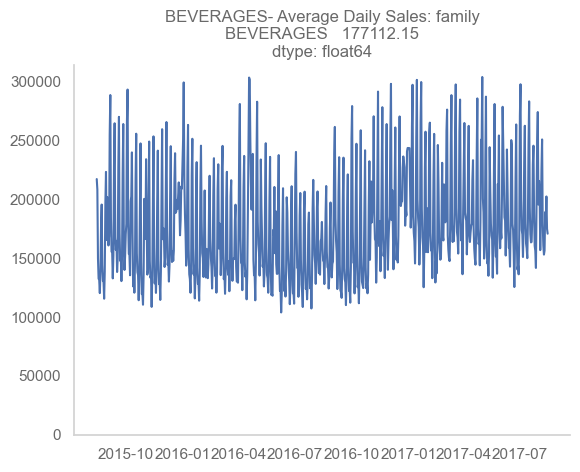

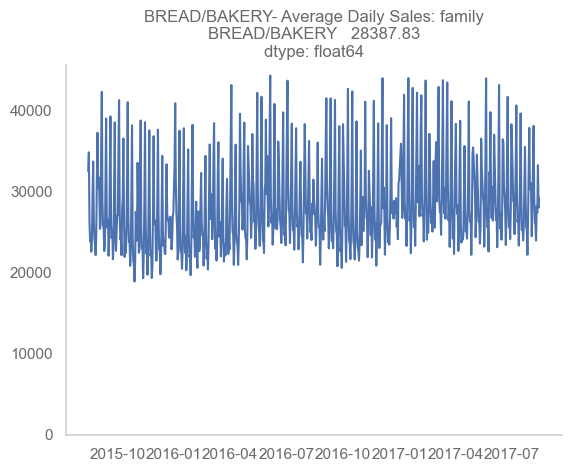

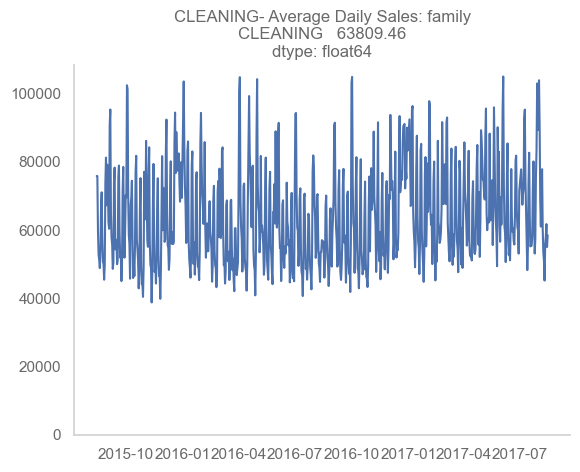

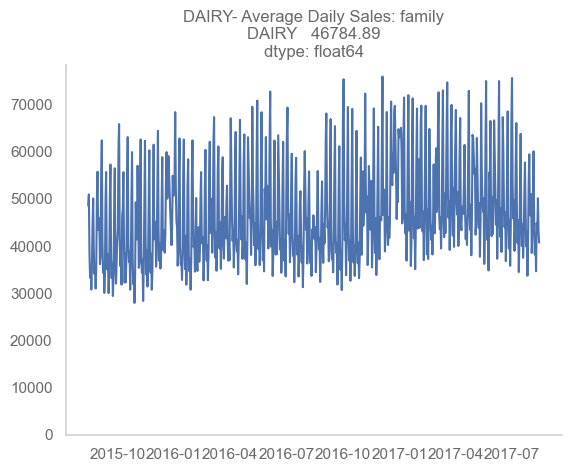

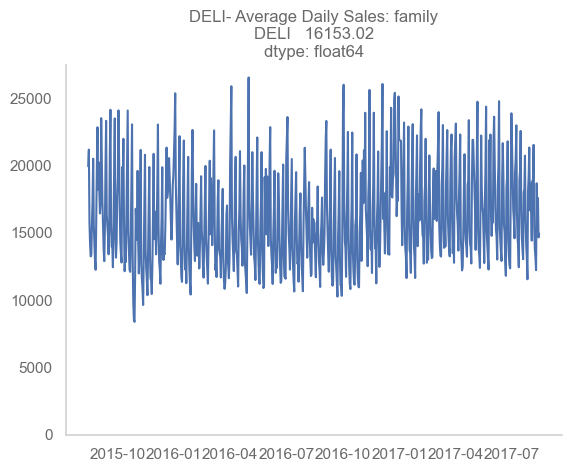

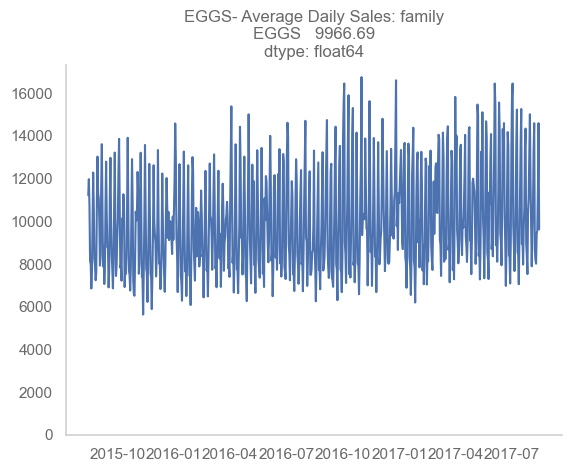

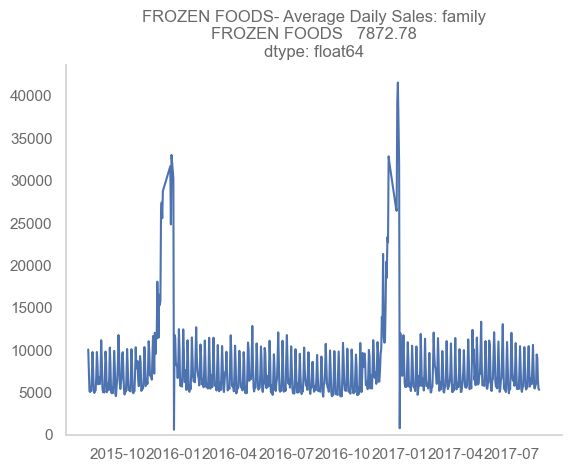

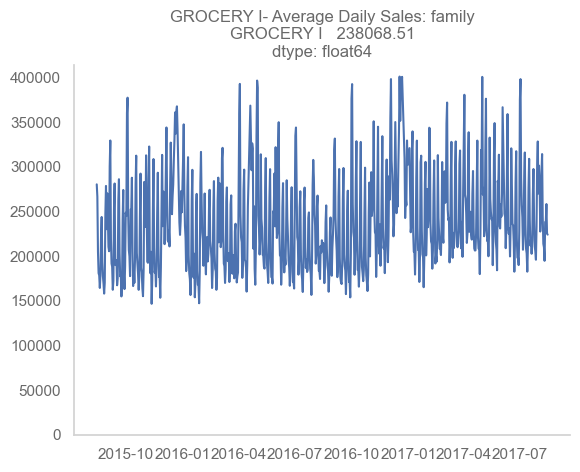

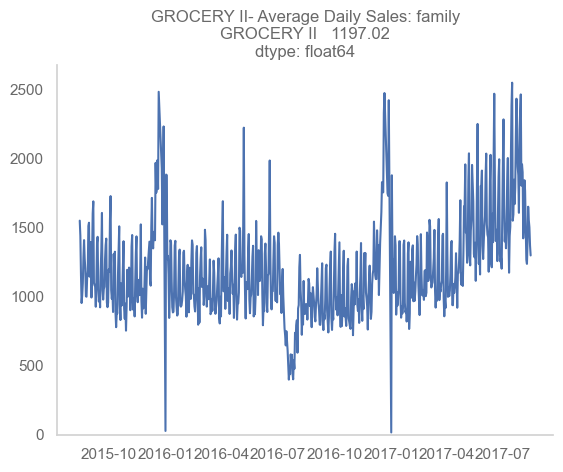

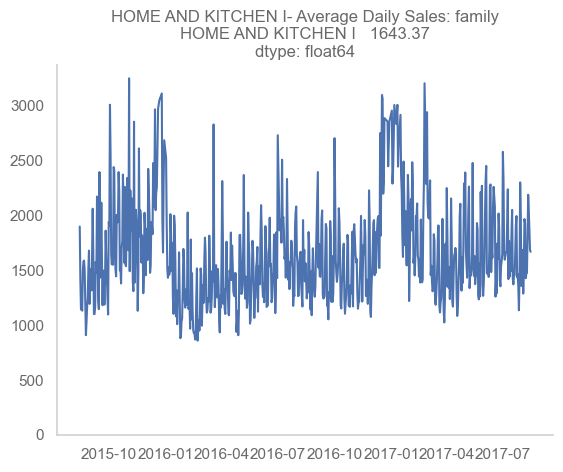

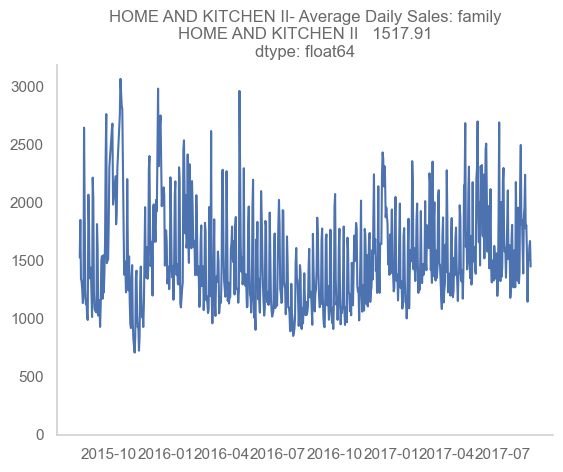

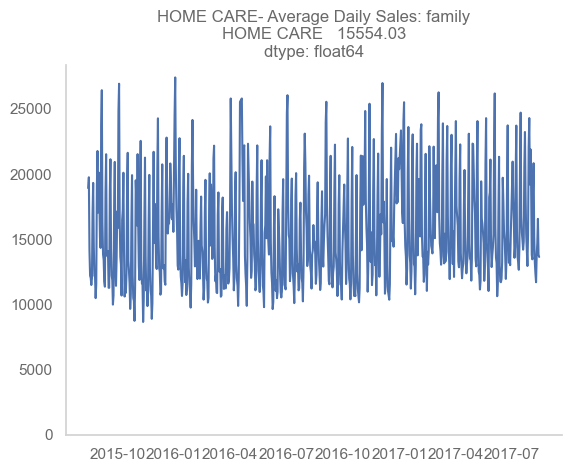

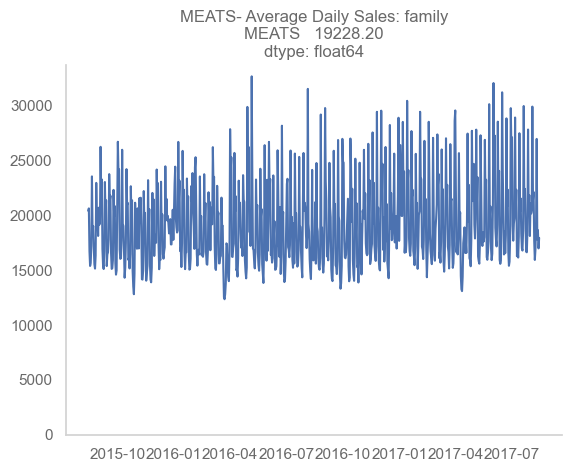

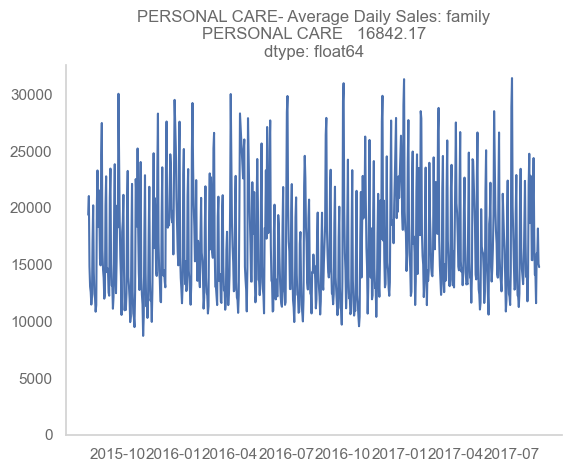

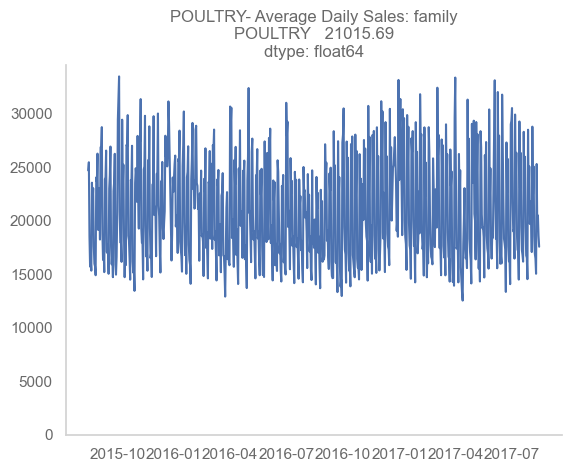

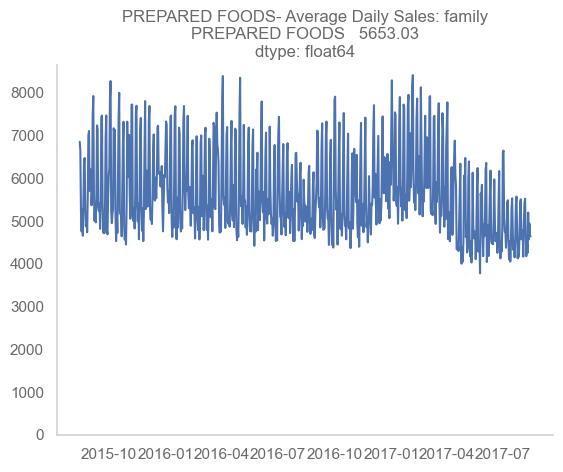

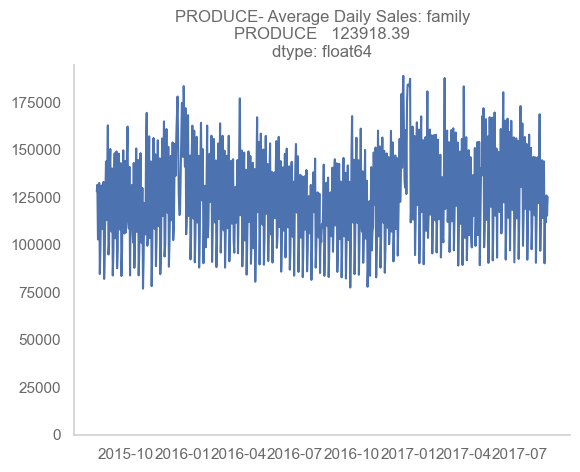

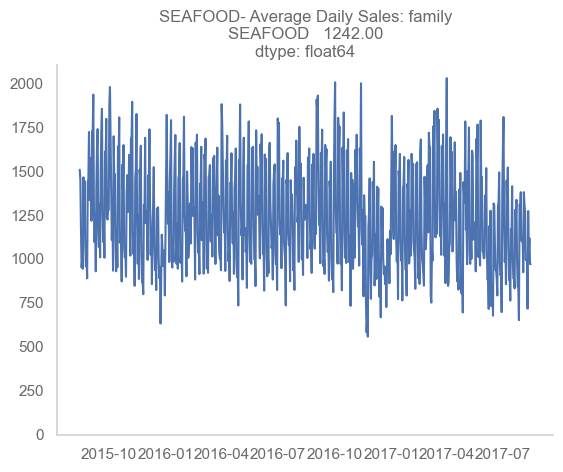

In [34]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

- This category follows a seasonal trend that will be good for forecasting after data cleaning

## HYPERPARAMETER TUNING AND BACKTESTING PIPELINE
- Ranges give on Prophet's documentation

- changepoint_prior_scale [0.001, 0.5]
- seasonality_prior_scale [0.01, 10]
- holidays_prior_scale [0.01, 10]
- seasonality_mode ['additive', 'multiplicative'].
- changepoint_range [0.5, 0.95]

In [35]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [36]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()


In [43]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

12:01:28 - cmdstanpy - INFO - Chain [1] start processing
12:01:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:01:28 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:30 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2028209799.08 45035.65 34020.77  0.33   0.16   0.20      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:36 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2165302599.09 46532.81 36449.14  0.37   0.17   0.22      0.54


  0%|          | 0/12 [00:00<?, ?it/s]

12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:41 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2168511862.02 46567.28 36416.93  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing
12:01:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:47 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2156294745.05 46435.92 36246.97  0.36   0.17   0.22      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing
12:01:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:54 -

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2160660388.20 46482.90 36402.67  0.37   0.17   0.22      0.55


  0%|          | 0/12 [00:00<?, ?it/s]

12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1026634525.53 32041.14 22229.23  0.29   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1010590127.30 31789.78 21554.45  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1006457975.82 31724.72 21475.57  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1011766896.10 31808.28 21620.93  0.30   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1012988434.95 31827.48 21578.52  0.30   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing
12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1044160884.22 32313.48 22185.85  0.30   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1063118529.32 32605.50 22110.63  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1079132064.65 32850.15 22359.07  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1077545731.15 32825.99 22319.58  0.31   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing
12:02:20 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1067599718.14 32674.14 22183.68  0.31   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1044933773.43 32325.44 22078.23  0.30   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1111733319.29 33342.67 23024.15  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1121132096.08 33483.31 23203.17  0.31   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1110799211.59 33328.65 23058.06  0.31   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1117021668.05 33421.87 23170.05  0.31   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:34 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1024394602.94 32006.17 21824.36  0.30   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1164552037.93 34125.53 23962.70  0.32   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1155797842.89 33997.03 23877.77  0.32   0.11   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1158164956.02 34031.82 23842.01  0.32   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1163580432.70 34111.29 23881.33  0.32   0.11   0.13      0.75
BEVERAGES
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.33
1                     0.00                     2.51  0.37
2                     0.00                     5.00  0.37
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.37


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:44 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing
12:02:45 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:45 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:45 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18054165.88 4249.02 2854.56  0.29   0.07   0.10      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20599117.92 4538.63 3212.78  0.31   0.08   0.11      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing
12:02:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing
12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing
12:02:57 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19907644.30 4461.80 3141.26  0.31   0.09   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18193988.74 4265.44 2961.87  0.30   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing
12:03:06 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing
12:03:06 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20175275.30 4491.69 3166.23  0.31   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:09 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:09 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14428867.45 3798.53 2578.39  0.29   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing
12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14747390.00 3840.23 2510.32  0.30   0.06   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14786508.69 3845.32 2511.54  0.30   0.06   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing
12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14804989.08 3847.73 2518.59  0.30   0.07   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing
12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14809709.15 3848.34 2526.77  0.30   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing
12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14065790.70 3750.44 2481.21  0.29   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:21 - cmdstanpy - INFO - Chain [1] start processing
12:03:21 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:22 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14499914.29 3807.88 2446.26  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14511037.78 3809.34 2449.50  0.30   0.07   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing
12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14478352.48 3805.04 2443.02  0.30   0.06   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing
12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14459012.04 3802.50 2440.22  0.30   0.06   0.08      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing
12:03:31 - cmdstanpy - INFO - Chain [1] start processing
12:03:31 - cmdstanpy - INFO - Chain [1] done processing
12:03:31 - cmdstanpy - INFO - Chain [1] start processing
12:03:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13822962.45 3717.92 2424.59  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:32 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:33 - cmdstanpy - INFO - Chain [1] done processing
12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14456851.61 3802.22 2430.25  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14425620.76 3798.11 2427.32  0.30   0.06   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1] done processing
12:03:37 - cmdstanpy - INFO - Chain [1] start processing
12:03:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14419146.81 3797.26 2424.03  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:38 - cmdstanpy - INFO - Chain [1] start processing
12:03:38 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1] done processing
12:03:39 - cmdstanpy - INFO - Chain [1] start processing
12:03:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14391927.06 3793.67 2421.74  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:40 - cmdstanpy - INFO - Chain [1] start processing
12:03:40 - cmdstanpy - INFO - Chain [1] done processing
12:03:40 - cmdstanpy - INFO - Chain [1] start processing
12:03:40 - cmdstanpy - INFO - Chain [1] done processing
12:03:40 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13729922.84 3705.39 2402.61  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:42 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:43 - cmdstanpy - INFO - Chain [1] done processing
12:03:43 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1] done processing
12:03:44 - cmdstanpy - INFO - Chain [1] start processing
12:03:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14350761.60 3788.24 2401.85  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:45 - cmdstanpy - INFO - Chain [1] done processing
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing
12:03:46 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14298824.92 3781.38 2394.41  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:47 - cmdstanpy - INFO - Chain [1] done processing
12:03:47 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14316289.80 3783.69 2397.95  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:49 - cmdstanpy - INFO - Chain [1] start processing
12:03:49 - cmdstanpy - INFO - Chain [1] done processing
12:03:49 - cmdstanpy - INFO - Chain [1] start processing
12:03:49 - cmdstanpy - INFO - Chain [1] done processing
12:03:49 - cmdstanpy - INFO - Chain [1] start processing
12:03:49 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:50 - cmdstanpy - INFO - Chain [1] done processing
12:03:50 - cmdstanpy - INFO - Chain [1] start processing
12:03:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14293586.57 3780.69 2394.90  0.30   0.06   0.08      0.82
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.29
1                     0.00                     2.51  0.31
2                     0.00                     5.00  0.31
3                     0.00                     7.50  0.30
4                     0.00                    10.00  0.31


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:51 - cmdstanpy - INFO - Chain [1] start processing
12:03:51 - cmdstanpy - INFO - Chain [1] done processing
12:03:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:03:51 - cmdstanpy - INFO - Chain [1] start processing
12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - INFO - Chain [1] start processing
12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - INFO - Chain [1] start processing
12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - INFO - Chain [1] start processing
12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - INFO - Chain [1] start processing
12:03:53 - cmdstanpy - INFO - Chain [1] done processing
12:03:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:03:53 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 270222264.61 16438.44 12141.10  0.71   0.15   0.19      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:56 - cmdstanpy - INFO - Chain [1] done processing
12:03:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:03:56 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:57 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] start processing
12:03:58 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - INFO - Chain [1] start processing
12:03:58 - cmdstanpy - INFO - Chain [1] done processing
12:03:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:03:58 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 296482736.32 17218.67 13014.67  0.78   0.17   0.22      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:01 - cmdstanpy - INFO - Chain [1] start processing
12:04:01 - cmdstanpy - INFO - Chain [1] done processing
12:04:01 - cmdstanpy - INFO - Chain [1] start processing
12:04:01 - cmdstanpy - INFO - Chain [1] done processing
12:04:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:01 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 311339941.81 17644.83 13544.80  0.78   0.18   0.23      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:03 - cmdstanpy - INFO - Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing
12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing
12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - INFO - Chain [1] start processing
12:04:04 - cmdstanpy - INFO - Chain [1] done processing
12:04:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:04 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 314832212.41 17743.51 13677.72  0.79   0.18   0.23      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - INFO - Chain [1] start processing
12:04:07 - cmdstanpy - INFO - Chain [1] done processing
12:04:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:07 -

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 294083227.48 17148.85 12905.33  0.77   0.17   0.21      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing
12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing
12:04:09 - cmdstanpy - INFO - Chain [1] start processing
12:04:09 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1] done processing
12:04:10 - cmdstanpy - INFO - Chain [1] start processing
12:04:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148045002.93 12167.37 8562.94  0.69   0.10   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:11 - cmdstanpy - INFO - Chain [1] done processing
12:04:11 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1] done processing
12:04:12 - cmdstanpy - INFO - Chain [1] start processing
12:04:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147179576.26 12131.76 8153.88  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:14 - cmdstanpy - INFO - Chain [1] start processing
12:04:14 - cmdstanpy - INFO - Chain [1] done processing
12:04:14 - cmdstanpy - INFO - Chain [1] start processing
12:04:14 - cmdstanpy - INFO - Chain [1] done processing
12:04:14 - cmdstanpy - INFO - Chain [1] start processing
12:04:14 - cmdstanpy - INFO - Chain [1] done processing
12:04:14 - cmdstanpy - INFO - Chain [1] start processing
12:04:14 - cmdstanpy - INFO - Chain [1] done processing
12:04:14 - cmdstanpy - INFO - Chain [1] start processing
12:04:14 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147203315.45 12132.74 8159.35  0.72   0.08   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:15 - cmdstanpy - INFO - Chain [1] start processing
12:04:15 - cmdstanpy - INFO - Chain [1] done processing
12:04:15 - cmdstanpy - INFO - Chain [1] start processing
12:04:15 - cmdstanpy - INFO - Chain [1] done processing
12:04:15 - cmdstanpy - INFO - Chain [1] start processing
12:04:15 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1] done processing
12:04:16 - cmdstanpy - INFO - Chain [1] start processing
12:04:16 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147274678.23 12135.68 8158.76  0.72   0.08   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:17 - cmdstanpy - INFO - Chain [1] start processing
12:04:17 - cmdstanpy - INFO - Chain [1] done processing
12:04:17 - cmdstanpy - INFO - Chain [1] start processing
12:04:17 - cmdstanpy - INFO - Chain [1] done processing
12:04:17 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147252013.46 12134.74 8153.02  0.72   0.08   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:19 - cmdstanpy - INFO - Chain [1] start processing
12:04:19 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1] done processing
12:04:20 - cmdstanpy - INFO - Chain [1] start processing
12:04:20 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 148173091.89 12172.64 8606.69  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:21 - cmdstanpy - INFO - Chain [1] start processing
12:04:21 - cmdstanpy - INFO - Chain [1] done processing
12:04:21 - cmdstanpy - INFO - Chain [1] start processing
12:04:21 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1] done processing
12:04:22 - cmdstanpy - INFO - Chain [1] start processing
12:04:22 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146186316.26 12090.75 8162.84  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1] done processing
12:04:24 - cmdstanpy - INFO - Chain [1] start processing
12:04:24 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 145813021.21 12075.31 8153.60  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:25 - cmdstanpy - INFO - Chain [1] done processing
12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:25 - cmdstanpy - INFO - Chain [1] done processing
12:04:25 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1] done processing
12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:26 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146007559.44 12083.36 8160.64  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:27 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146250944.20 12093.43 8171.74  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:29 - cmdstanpy - INFO - Chain [1] start processing
12:04:29 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing
12:04:31 - cmdstanpy - INFO - Chain [1] start processing
12:04:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 149671981.55 12234.05 8631.88  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:32 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146537159.70 12105.25 8188.78  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:34 - cmdstanpy - INFO - Chain [1] start processing
12:04:34 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1] done processing
12:04:35 - cmdstanpy - INFO - Chain [1] start processing
12:04:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146636756.61 12109.37 8176.62  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing
12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:37 - cmdstanpy - INFO - Chain [1] done processing
12:04:37 - cmdstanpy - INFO - Chain [1] start processing
12:04:37 - cmdstanpy - INFO - Chain [1] done processing
12:04:37 - cmdstanpy - INFO - Chain [1] start processing
12:04:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146243729.20 12093.13 8179.01  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146676809.39 12111.02 8187.03  0.73   0.09   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:40 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:41 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 150607447.25 12272.22 8688.31  0.70   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:42 - cmdstanpy - INFO - Chain [1] done processing
12:04:42 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1] done processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1] done processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147038613.99 12125.95 8220.09  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146989436.70 12123.92 8224.32  0.73   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:46 - cmdstanpy - INFO - Chain [1] start processing
12:04:46 - cmdstanpy - INFO - Chain [1] done processing
12:04:47 - cmdstanpy - INFO - Chain [1] start processing
12:04:47 - cmdstanpy - INFO - Chain [1] done processing
12:04:47 - cmdstanpy - INFO - Chain [1] start processing
12:04:47 - cmdstanpy - INFO - Chain [1] done processing
12:04:47 - cmdstanpy - INFO - Chain [1] start processing
12:04:47 - cmdstanpy - INFO - Chain [1] done processing
12:04:47 - cmdstanpy - INFO - Chain [1] start processing
12:04:47 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 146731641.06 12113.28 8213.23  0.73   0.09   0.12      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:48 - cmdstanpy - INFO - Chain [1] start processing
12:04:48 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1] done processing
12:04:49 - cmdstanpy - INFO - Chain [1] start processing
12:04:49 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 147302524.28 12136.83 8230.05  0.73   0.09   0.12      0.78
CLEANING
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.71
1                     0.00                     2.51  0.78
2                     0.00                     5.00  0.78
3                     0.00                     7.50  0.79
4                     0.00                    10.00  0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:50 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing
12:04:50 - cmdstanpy - INFO - Chain [1] done processing
12:04:50 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:52 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] start processing
12:04:52 - cmdstanpy - INFO - Chain [1] done processing
12:04:52 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67755423.59 8231.37 5428.14  0.38   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:54 - cmdstanpy - INFO - Chain [1] done processing
12:04:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:54 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start processing
12:04:55 - cmdstanpy - INFO - Chain [1] done processing
12:04:55 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73255831.48 8558.96 5913.48  0.41   0.10   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:58 - cmdstanpy - INFO - Chain [1] done processing
12:04:58 - cmdstanpy - INFO - Chain [1] start processing
12:04:58 - cmdstanpy - INFO - Chain [1] done processing
12:04:58 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73129835.53 8551.60 5933.16  0.41   0.10   0.12      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:00 - cmdstanpy - INFO - Chain [1] start processing
12:05:00 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start processing
12:05:01 - cmdstanpy - INFO - Chain [1] done processing
12:05:01 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73925068.82 8597.97 5972.69  0.41   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:04 - cmdstanpy - INFO - Chain [1] done processing
12:05:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:04 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start processing
12:05:05 - cmdstanpy - INFO - Chain [1] done processing
12:05:05 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 72020289.33 8486.48 5830.48  0.41   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing
12:05:08 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52016638.21 7212.26 4866.34  0.38   0.08   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:09 - cmdstanpy - INFO - Chain [1] start processing
12:05:09 - cmdstanpy - INFO - Chain [1] done processing
12:05:10 - cmdstanpy - INFO - Chain [1] start processing
12:05:10 - cmdstanpy - INFO - Chain [1] done processing
12:05:10 - cmdstanpy - INFO - Chain [1] start processing
12:05:10 - cmdstanpy - INFO - Chain [1] done processing
12:05:10 - cmdstanpy - INFO - Chain [1] start processing
12:05:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48020655.83 6929.69 4407.32  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:11 - cmdstanpy - INFO - Chain [1] start processing
12:05:11 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47899566.42 6920.95 4396.96  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:13 - cmdstanpy - INFO - Chain [1] start processing
12:05:13 - cmdstanpy - INFO - Chain [1] done processing
12:05:14 - cmdstanpy - INFO - Chain [1] start processing
12:05:14 - cmdstanpy - INFO - Chain [1] done processing
12:05:14 - cmdstanpy - INFO - Chain [1] start processing
12:05:14 - cmdstanpy - INFO - Chain [1] done processing
12:05:14 - cmdstanpy - INFO - Chain [1] start processing
12:05:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47919634.43 6922.40 4400.18  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:15 - cmdstanpy - INFO - Chain [1] done processing
12:05:15 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1] done processing
12:05:16 - cmdstanpy - INFO - Chain [1] start processing
12:05:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47979375.65 6926.71 4401.33  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:17 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52178763.85 7223.49 4813.81  0.38   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:19 - cmdstanpy - INFO - Chain [1] done processing
12:05:19 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1] done processing
12:05:20 - cmdstanpy - INFO - Chain [1] start processing
12:05:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47589061.18 6898.48 4326.01  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:21 - cmdstanpy - INFO - Chain [1] start processing
12:05:21 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing
12:05:22 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47644246.74 6902.48 4337.69  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47619531.43 6900.69 4326.95  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:25 - cmdstanpy - INFO - Chain [1] done processing
12:05:25 - cmdstanpy - INFO - Chain [1] start processing
12:05:26 - cmdstanpy - INFO - Chain [1] done processing
12:05:26 - cmdstanpy - INFO - Chain [1] start processing
12:05:26 - cmdstanpy - INFO - Chain [1] done processing
12:05:26 - cmdstanpy - INFO - Chain [1] start processing
12:05:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47566876.61 6896.87 4324.39  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:27 - cmdstanpy - INFO - Chain [1] start processing
12:05:27 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1] done processing
12:05:28 - cmdstanpy - INFO - Chain [1] start processing
12:05:28 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52461919.78 7243.06 4820.12  0.38   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47680347.22 6905.10 4306.87  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:31 - cmdstanpy - INFO - Chain [1] start processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] start processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] start processing
12:05:31 - cmdstanpy - INFO - Chain [1] done processing
12:05:31 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1] done processing
12:05:32 - cmdstanpy - INFO - Chain [1] start processing
12:05:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47723416.59 6908.21 4316.34  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:33 - cmdstanpy - INFO - Chain [1] start processing
12:05:33 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:34 - cmdstanpy - INFO - Chain [1] done processing
12:05:34 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47688174.25 6905.66 4319.22  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing
12:05:37 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47670705.52 6904.40 4306.48  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:38 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1] done processing
12:05:39 - cmdstanpy - INFO - Chain [1] start processing
12:05:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52464044.35 7243.21 4823.61  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:40 - cmdstanpy - INFO - Chain [1] done processing
12:05:40 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:41 - cmdstanpy - INFO - Chain [1] start processing
12:05:41 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47780051.73 6912.31 4298.61  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:43 - cmdstanpy - INFO - Chain [1] done processing
12:05:43 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1] done processing
12:05:44 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1] done processing
12:05:44 - cmdstanpy - INFO - Chain [1] start processing
12:05:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47826947.30 6915.70 4299.86  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:45 - cmdstanpy - INFO - Chain [1] done processing
12:05:45 - cmdstanpy - INFO - Chain [1] start processing
12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:46 - cmdstanpy - INFO - Chain [1] start processing
12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:46 - cmdstanpy - INFO - Chain [1] start processing
12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:46 - cmdstanpy - INFO - Chain [1] start processing
12:05:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47861567.00 6918.21 4300.66  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:47 - cmdstanpy - INFO - Chain [1] start processing
12:05:47 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47802545.46 6913.94 4297.93  0.38   0.06   0.09      0.86
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:49 - cmdstanpy - INFO - Chain [1] start processing
12:05:49 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:50 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start processing
12:05:51 - cmdstanpy - INFO - Chain [1] done processing
12:05:51 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16085372.94 4010.66 2928.39  0.45   0.13   0.19      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:55 - cmdstanpy - INFO - Chain [1] start processing
12:05:55 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:56 - cmdstanpy - INFO - Chain [1] done processing
12:05:56 - cmdstanpy - INFO - Chain [1] start processing
12:05:57 - cmdstanpy - INFO - Chain [1] done processing
12:05:57 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17644363.11 4200.52 3096.54  0.48   0.14   0.21      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19277709.62 4390.64 3338.68  0.50   0.17   0.23      0.57


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:04 - cmdstanpy - INFO - Chain [1] start processing
12:06:04 - cmdstanpy - INFO - Chain [1] done processing
12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing
12:06:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:05 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start processing
12:06:06 - cmdstanpy - INFO - Chain [1] done processing
12:06:06 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19372125.12 4401.38 3370.01  0.50   0.17   0.23      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:09 - cmdstanpy - INFO - Chain [1] start processing
12:06:09 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing
12:06:10 - cmdstanpy - INFO - Chain [1] start processing
12:06:11 - cmdstanpy - INFO - Chain [1] done processing
12:06:11 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18157671.79 4261.18 3161.93  0.49   0.15   0.22      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:14 - cmdstanpy - INFO - Chain [1] start processing
12:06:14 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1] done processing
12:06:15 - cmdstanpy - INFO - Chain [1] start processing
12:06:15 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7758080.28 2785.33 1935.70  0.44   0.10   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:16 - cmdstanpy - INFO - Chain [1] start processing
12:06:16 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7995308.20 2827.60 1870.26  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:19 - cmdstanpy - INFO - Chain [1] start processing
12:06:19 - cmdstanpy - INFO - Chain [1] done processing
12:06:20 - cmdstanpy - INFO - Chain [1] start processing
12:06:20 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7970800.83 2823.26 1861.24  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:21 - cmdstanpy - INFO - Chain [1] start processing
12:06:21 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1] done processing
12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8026305.52 2833.07 1881.12  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1] done processing
12:06:24 - cmdstanpy - INFO - Chain [1] start processing
12:06:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7988691.99 2826.43 1870.86  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:25 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1] done processing
12:06:26 - cmdstanpy - INFO - Chain [1] start processing
12:06:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7708364.28 2776.39 1912.77  0.44   0.10   0.12      0.82


12:06:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:27 - cmdstanpy - INFO - Chain [1] start processing
12:06:27 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1] done processing
12:06:28 - cmdstanpy - INFO - Chain [1] start processing
12:06:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8025501.23 2832.93 1872.81  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:30 - cmdstanpy - INFO - Chain [1] done processing
12:06:30 - cmdstanpy - INFO - Chain [1] start processing
12:06:31 - cmdstanpy - INFO - Chain [1] done processing
12:06:31 - cmdstanpy - INFO - Chain [1] start processing
12:06:31 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8048603.23 2837.01 1877.86  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:32 - cmdstanpy - INFO - Chain [1] start processing
12:06:32 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1] done processing
12:06:33 - cmdstanpy - INFO - Chain [1] start processing
12:06:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8041259.89 2835.71 1876.74  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1] done processing
12:06:35 - cmdstanpy - INFO - Chain [1] start processing
12:06:35 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8018974.14 2831.78 1870.91  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:36 - cmdstanpy - INFO - Chain [1] start processing
12:06:36 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1] done processing
12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7739116.35 2781.93 1911.25  0.44   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:38 - cmdstanpy - INFO - Chain [1] start processing
12:06:38 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:40 - cmdstanpy - INFO - Chain [1] start processing
12:06:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8088432.17 2844.02 1878.53  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:41 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1] done processing
12:06:42 - cmdstanpy - INFO - Chain [1] start processing
12:06:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8094152.64 2845.02 1883.60  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:43 - cmdstanpy - INFO - Chain [1] start processing
12:06:43 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8080480.98 2842.62 1882.05  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1] done processing
12:06:46 - cmdstanpy - INFO - Chain [1] start processing
12:06:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8079581.00 2842.46 1878.56  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:47 - cmdstanpy - INFO - Chain [1] start processing
12:06:47 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing
12:06:48 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7702938.00 2775.42 1901.86  0.44   0.09   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing
12:06:51 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8166208.23 2857.66 1895.80  0.46   0.08   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:52 - cmdstanpy - INFO - Chain [1] done processing
12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1] done processing
12:06:53 - cmdstanpy - INFO - Chain [1] start processing
12:06:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8169343.72 2858.21 1896.15  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:54 - cmdstanpy - INFO - Chain [1] done processing
12:06:54 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1] done processing
12:06:55 - cmdstanpy - INFO - Chain [1] start processing
12:06:55 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8173927.62 2859.01 1896.73  0.46   0.08   0.12      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:57 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1] done processing
12:06:58 - cmdstanpy - INFO - Chain [1] start processing
12:06:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8192648.96 2862.28 1903.05  0.46   0.09   0.12      0.82
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.45
1                     0.00                     2.51  0.48
2                     0.00                     5.00  0.50
3                     0.00                     7.50  0.50
4                     0.00                    10.00  0.49


  0%|          | 0/12 [00:00<?, ?it/s]

12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:06:59 - cmdstanpy - INFO - Chain [1] done processing
12:06:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - INFO - Chain [1] start processing
12:07:00 - cmdstanpy - INFO - Chain [1] done processing
12:07:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:00 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4954905.46 2225.96 1406.38  0.47   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:03 - cmdstanpy - INFO - Chain [1] start processing
12:07:03 - cmdstanpy - INFO - Chain [1] done processing
12:07:04 - cmdstanpy - INFO - Chain [1] start processing
12:07:04 - cmdstanpy - INFO - Chain [1] done processing
12:07:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:04 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4930623.89 2220.50 1362.84  0.47   0.08   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:06 - cmdstanpy - INFO - Chain [1] start processing
12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - INFO - Chain [1] start processing
12:07:07 - cmdstanpy - INFO - Chain [1] done processing
12:07:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:07 - cmdstanpy - INFO - Chain [1] start processing
12:07:09 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing
12:07:10 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing
12:07:10 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - INFO - Chain [1] start processing
12:07:10 - cmdstanpy - INFO - Chain [1] done processing
12:07:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:10 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4973669.24 2230.17 1398.54  0.48   0.09   0.14      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:13 - cmdstanpy - INFO - Chain [1] done processing
12:07:13 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:14 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 5054038.75 2248.12 1411.82  0.48   0.09   0.14      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - INFO - Chain [1] start processing
12:07:18 - cmdstanpy - INFO - Chain [1] done processing
12:07:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:18 -

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 4938440.50 2222.26 1380.59  0.48   0.09   0.13      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:21 - cmdstanpy - INFO - Chain [1] start processing
12:07:21 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1] done processing
12:07:22 - cmdstanpy - INFO - Chain [1] start processing
12:07:22 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3792998.90 1947.56 1258.70  0.49   0.08   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:23 - cmdstanpy - INFO - Chain [1] start processing
12:07:23 - cmdstanpy - INFO - Chain [1] done processing
12:07:23 - cmdstanpy - INFO - Chain [1] start processing
12:07:23 - cmdstanpy - INFO - Chain [1] done processing
12:07:23 - cmdstanpy - INFO - Chain [1] start processing
12:07:23 - cmdstanpy - INFO - Chain [1] done processing
12:07:23 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing
12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3499768.28 1870.77 1155.83  0.49   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:25 - cmdstanpy - INFO - Chain [1] start processing
12:07:25 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3503288.53 1871.71 1154.72  0.49   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1] done processing
12:07:28 - cmdstanpy - INFO - Chain [1] start processing
12:07:28 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3521797.97 1876.65 1155.22  0.49   0.08   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:29 - cmdstanpy - INFO - Chain [1] done processing
12:07:29 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1] done processing
12:07:30 - cmdstanpy - INFO - Chain [1] start processing
12:07:30 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3473423.74 1863.71 1147.34  0.49   0.08   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:31 - cmdstanpy - INFO - Chain [1] start processing
12:07:31 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1] done processing
12:07:32 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3825971.09 1956.01 1261.83  0.49   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1] done processing
12:07:34 - cmdstanpy - INFO - Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3469559.96 1862.68 1168.91  0.48   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:35 - cmdstanpy - INFO - Chain [1] start processing
12:07:35 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1] done processing
12:07:36 - cmdstanpy - INFO - Chain [1] start processing
12:07:36 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3472201.93 1863.38 1170.31  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:37 - cmdstanpy - INFO - Chain [1] start processing
12:07:37 - cmdstanpy - INFO - Chain [1] done processing
12:07:37 - cmdstanpy - INFO - Chain [1] start processing
12:07:37 - cmdstanpy - INFO - Chain [1] done processing
12:07:37 - cmdstanpy - INFO - Chain [1] start processing
12:07:37 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1] done processing
12:07:38 - cmdstanpy - INFO - Chain [1] start processing
12:07:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3461425.55 1860.49 1165.58  0.48   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3456387.25 1859.14 1166.95  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:42 - cmdstanpy - INFO - Chain [1] start processing
12:07:42 - cmdstanpy - INFO - Chain [1] done processing
12:07:43 - cmdstanpy - INFO - Chain [1] start processing
12:07:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3835598.46 1958.47 1268.01  0.49   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:44 - cmdstanpy - INFO - Chain [1] start processing
12:07:44 - cmdstanpy - INFO - Chain [1] done processing
12:07:45 - cmdstanpy - INFO - Chain [1] start processing
12:07:45 - cmdstanpy - INFO - Chain [1] done processing
12:07:45 - cmdstanpy - INFO - Chain [1] start processing
12:07:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3465763.10 1861.66 1181.51  0.49   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1] done processing
12:07:47 - cmdstanpy - INFO - Chain [1] start processing
12:07:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3469530.76 1862.67 1181.77  0.49   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:48 - cmdstanpy - INFO - Chain [1] start processing
12:07:48 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing
12:07:48 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing
12:07:48 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing
12:07:48 - cmdstanpy - INFO - Chain [1] done processing
12:07:48 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1] done processing
12:07:49 - cmdstanpy - INFO - Chain [1] start processing
12:07:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3458565.18 1859.72 1179.05  0.49   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing
12:07:50 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1] done processing
12:07:51 - cmdstanpy - INFO - Chain [1] start processing
12:07:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3461999.58 1860.64 1179.10  0.49   0.07   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:54 - cmdstanpy - INFO - Chain [1] done processing
12:07:54 - cmdstanpy - INFO - Chain [1] start processing
12:07:54 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3817374.49 1953.81 1266.12  0.49   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:55 - cmdstanpy - INFO - Chain [1] start processing
12:07:55 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1] done processing
12:07:56 - cmdstanpy - INFO - Chain [1] start processing
12:07:56 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3437019.37 1853.92 1177.30  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:07:57 - cmdstanpy - INFO - Chain [1] start processing
12:07:57 - cmdstanpy - INFO - Chain [1] done processing
12:07:57 - cmdstanpy - INFO - Chain [1] start processing
12:07:57 - cmdstanpy - INFO - Chain [1] done processing
12:07:57 - cmdstanpy - INFO - Chain [1] start processing
12:07:57 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing
12:07:58 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3445415.85 1856.18 1182.02  0.49   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:00 - cmdstanpy - INFO - Chain [1] start processing
12:08:00 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1] done processing
12:08:01 - cmdstanpy - INFO - Chain [1] start processing
12:08:01 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3430908.62 1852.27 1174.48  0.48   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:02 - cmdstanpy - INFO - Chain [1] done processing
12:08:02 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing
12:08:03 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing
12:08:03 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1] done processing
12:08:03 - cmdstanpy - INFO - Chain [1] start processing
12:08:03 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 3433086.82 1852.86 1175.77  0.48   0.08   0.11      0.81
EGGS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.47
2                     0.00                     5.00  0.48
3                     0.00                     7.50  0.48
4                     0.00                    10.00  0.48


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:04 - cmdstanpy - INFO - Chain [1] start processing
12:08:04 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:05 - cmdstanpy - INFO - Chain [1] done processing
12:08:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:07 - cmdstanpy - INFO - Chain [1] done processing
12:08:07 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47078491.39 6861.38 3639.28  0.47   0.32   0.44      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:08 - cmdstanpy - INFO - Chain [1] done processing
12:08:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:08 - cmdstanpy - INFO - Chain [1] start processing
12:08:09 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start processing
12:08:09 - cmdstanpy - INFO - Chain [1] done processing
12:08:09 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53219872.69 7295.20 4206.05  0.56   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:10 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:12 - cmdstanpy - INFO - Chain [1] start processing
12:08:12 - cmdstanpy - INFO - Chain [1] done processing
12:08:12 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012052.47 7280.94 4170.86  0.55   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:13 - cmdstanpy - INFO - Chain [1] done processing
12:08:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:13 - cmdstanpy - INFO - Chain [1] start processing
12:08:14 - cmdstanpy - INFO - Chain [1] done processing
12:08:14 - cmdstanpy - INFO - Chain [1] start processing
12:08:14 - cmdstanpy - INFO - Chain [1] done processing
12:08:14 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51046751.10 7144.70 4127.38  0.55   0.37   0.56      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:08:15 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53379575.42 7306.13 4232.02  0.56   0.38   0.57      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:18 - cmdstanpy - INFO - Chain [1] start processing
12:08:18 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1] done processing
12:08:19 - cmdstanpy - INFO - Chain [1] start processing
12:08:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53089799.84 7286.27 4019.94  0.53   0.32   0.45      0.91


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:20 - cmdstanpy - INFO - Chain [1] start processing
12:08:20 - cmdstanpy - INFO - Chain [1] done processing
12:08:20 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:21 - cmdstanpy - INFO - Chain [1] start processing
12:08:21 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49449816.47 7032.06 3800.57  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:23 - cmdstanpy - INFO - Chain [1] done processing
12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing
12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49573480.98 7040.84 3802.87  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:24 - cmdstanpy - INFO - Chain [1] start processing
12:08:24 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:25 - cmdstanpy - INFO - Chain [1] start processing
12:08:25 - cmdstanpy - INFO - Chain [1] done processing
12:08:26 - cmdstanpy - INFO - Chain [1] start processing
12:08:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49440410.34 7031.39 3795.79  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:26 - cmdstanpy - INFO - Chain [1] start processing
12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:26 - cmdstanpy - INFO - Chain [1] start processing
12:08:26 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49513297.60 7036.57 3799.24  0.50   0.33   0.42      0.92


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:28 - cmdstanpy - INFO - Chain [1] start processing
12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:29 - cmdstanpy - INFO - Chain [1] start processing
12:08:29 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1] done processing
12:08:30 - cmdstanpy - INFO - Chain [1] start processing
12:08:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 59216169.54 7695.20 4363.03  0.58   0.35   0.45      0.90


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:31 - cmdstanpy - INFO - Chain [1] start processing
12:08:31 - cmdstanpy - INFO - Chain [1] done processing
12:08:31 - cmdstanpy - INFO - Chain [1] start processing
12:08:31 - cmdstanpy - INFO - Chain [1] done processing
12:08:31 - cmdstanpy - INFO - Chain [1] start processing
12:08:31 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50070955.42 7076.08 3809.73  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing
12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:34 - cmdstanpy - INFO - Chain [1] done processing
12:08:34 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49980574.53 7069.69 3803.90  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:35 - cmdstanpy - INFO - Chain [1] start processing
12:08:35 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:36 - cmdstanpy - INFO - Chain [1] start processing
12:08:36 - cmdstanpy - INFO - Chain [1] done processing
12:08:37 - cmdstanpy - INFO - Chain [1] start processing
12:08:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50005365.03 7071.45 3809.93  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:37 - cmdstanpy - INFO - Chain [1] start processing
12:08:37 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50114885.48 7079.19 3814.09  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:39 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:40 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing
12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing
12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing
12:08:41 - cmdstanpy - INFO - Chain [1] done processing
12:08:41 - cmdstanpy - INFO - Chain [1] start processing
12:08:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 65195631.47 8074.38 4701.01  0.63   0.37   0.50      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:42 - cmdstanpy - INFO - Chain [1] start processing
12:08:42 - cmdstanpy - INFO - Chain [1] done processing
12:08:42 - cmdstanpy - INFO - Chain [1] start processing
12:08:42 - cmdstanpy - INFO - Chain [1] done processing
12:08:42 - cmdstanpy - INFO - Chain [1] start processing
12:08:42 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52122876.54 7219.62 3847.96  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51798542.57 7197.12 3841.39  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51827218.67 7199.11 3840.46  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52131645.20 7220.22 3846.96  0.50   0.32   0.42      0.92


12:08:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing
12:08:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73044032.29 8546.58 4867.11  0.65   0.35   0.51      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing
12:08:54 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53849091.41 7338.19 3885.71  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:56 - cmdstanpy - INFO - Chain [1] start processing
12:08:56 - cmdstanpy - INFO - Chain [1] done processing
12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing
12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1] done processing
12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:08:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53866945.38 7339.41 3887.15  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1] done processing
12:08:59 - cmdstanpy - INFO - Chain [1] start processing
12:08:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54059731.55 7352.53 3893.32  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:00 - cmdstanpy - INFO - Chain [1] start processing
12:09:00 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54318802.40 7370.13 3903.48  0.50   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.56
2                     0.00                     5.00  0.55
3                     0.00                     7.50  0.55
4                     0.00                    10.00  0.56


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing
12:09:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing
12:09:03 - cmdstanpy - INFO - Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing
12:09:03 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3169718514.78 56300.25 41948.20  0.59   0.13   0.18      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:04 - cmdstanpy - INFO - Chain [1] done processing
12:09:04 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:05 - cmdstanpy - INFO - Chain [1] done processing
12:09:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:05 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing
12:09:06 - cmdstanpy - INFO - Chain [1] start processing
12:09:06 - cmdstanpy - INFO - Chain [1] done processing
12:09:06 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3545100096.64 59540.74 46092.81  0.63   0.16   0.20      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:08 - cmdstanpy - INFO - Chain [1] start processing
12:09:08 - cmdstanpy - INFO - Chain [1] done processing
12:09:09 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3533888237.94 59446.52 45904.70  0.63   0.15   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing
12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing
12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing
12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing
12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:10 - cmdstanpy - INFO - Chain [1] done processing
12:09:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:10 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
12:09:11 - cmdstanpy - INFO - Chain [1] start processing
12:09:11 - cmdstanpy - INFO - Chain [1] done processing
12:09:11 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3469021491.69 58898.40 44966.14  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3466820829.22 58879.71 45098.26  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:15 - cmdstanpy - INFO - Chain [1] done processing
12:09:15 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1] done processing
12:09:16 - cmdstanpy - INFO - Chain [1] start processing
12:09:16 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948167344.47 44138.05 30187.18  0.57   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:17 - cmdstanpy - INFO - Chain [1] start processing
12:09:17 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1945276890.70 44105.29 29461.67  0.57   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1939291043.47 44037.38 29330.77  0.57   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1951925083.62 44180.60 29495.67  0.57   0.08   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1938766392.55 44031.43 29338.40  0.57   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1] done processing
12:09:26 - cmdstanpy - INFO - Chain [1] start processing
12:09:26 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 2000491199.43 44726.85 30606.83  0.58   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1] done processing
12:09:28 - cmdstanpy - INFO - Chain [1] start processing
12:09:28 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1956385351.10 44231.05 29779.89  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:29 - cmdstanpy - INFO - Chain [1] done processing
12:09:29 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1949934810.65 44158.07 29715.68  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:31 - cmdstanpy - INFO - Chain [1] done processing
12:09:31 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:32 - cmdstanpy - INFO - Chain [1] start processing
12:09:32 - cmdstanpy - INFO - Chain [1] done processing
12:09:33 - cmdstanpy - INFO - Chain [1] start processing
12:09:33 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1955791889.93 44224.34 29784.10  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:34 - cmdstanpy - INFO - Chain [1] start processing
12:09:34 - cmdstanpy - INFO - Chain [1] done processing
12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1] done processing
12:09:35 - cmdstanpy - INFO - Chain [1] start processing
12:09:35 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1952430030.27 44186.31 29768.18  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing
12:09:37 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1983400087.94 44535.38 30539.55  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:38 - cmdstanpy - INFO - Chain [1] start processing
12:09:38 - cmdstanpy - INFO - Chain [1] done processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1] done processing
12:09:39 - cmdstanpy - INFO - Chain [1] start processing
12:09:39 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1945667753.78 44109.72 29748.36  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing
12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing
12:09:40 - cmdstanpy - INFO - Chain [1] start processing
12:09:40 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1] done processing
12:09:41 - cmdstanpy - INFO - Chain [1] start processing
12:09:41 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1947038076.85 44125.25 29756.81  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1954519467.71 44209.95 29851.26  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:44 - cmdstanpy - INFO - Chain [1] start processing
12:09:44 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:45 - cmdstanpy - INFO - Chain [1] done processing
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
12:09:46 - cmdstanpy - INFO - Chain [1] done processing
12:09:46 - cmdstanpy - INFO - Chain [1] start processing
12:09:46 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1942932903.15 44078.71 29731.43  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:47 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1] done processing
12:09:48 - cmdstanpy - INFO - Chain [1] start processing
12:09:48 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1973826624.26 44427.77 30443.32  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1] done processing
12:09:50 - cmdstanpy - INFO - Chain [1] start processing
12:09:50 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1937534714.37 44017.44 29896.28  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing
12:09:51 - cmdstanpy - INFO - Chain [1] start processing
12:09:51 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing
12:09:52 - cmdstanpy - INFO - Chain [1] start processing
12:09:53 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1938128997.02 44024.19 29926.47  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:54 - cmdstanpy - INFO - Chain [1] start processing
12:09:54 - cmdstanpy - INFO - Chain [1] done processing
12:09:55 - cmdstanpy - INFO - Chain [1] start processing
12:09:55 - cmdstanpy - INFO - Chain [1] done processing
12:09:55 - cmdstanpy - INFO - Chain [1] start processing
12:09:55 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1936785653.26 44008.93 29887.44  0.59   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing
12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing
12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1] done processing
12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:57 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1936716563.55 44008.14 29893.21  0.59   0.09   0.12      0.83
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.63
4                     0.00                    10.00  0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing
12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing
12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing
12:09:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:58 - cmdstanpy - INFO - Chain [1] done processing
12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing
12:09:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing
12:09:59 - cmdstanpy - INFO - Chain [1] start processing
12:09:59 - cmdstanpy - INFO - Chain [1] done processing
12:09:59 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 321227.90 566.77 424.51  0.57   0.29   0.36      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:04 - cmdstanpy - INFO - Chain [1] done processing
12:10:04 - cmdstanpy - INFO - Chain [1] start processing
12:10:04 - cmdstanpy - INFO - Chain [1] done processing
12:10:04 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 341270.04 584.18 451.75  0.63   0.32   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing
12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:09 - cmdstanpy - INFO - Chain [1] done processing
12:10:09 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 344160.65 586.65 453.80  0.63   0.33   0.40      0.61


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing
12:10:12 - cmdstanpy - INFO - Chain [1] start processing
12:10:12 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - INFO - Chain [1] start processing
12:10:14 - cmdstanpy - INFO - Chain [1] done processing
12:10:14 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 342010.54 584.82 453.74  0.64   0.32   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing
12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing
12:10:17 - cmdstanpy - INFO - Chain [1] start processing
12:10:17 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 341842.50 584.67 453.58  0.64   0.33   0.40      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing
12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing
12:10:22 - cmdstanpy - INFO - Chain [1] start processing
12:10:22 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1] done processing
12:10:23 - cmdstanpy - INFO - Chain [1] start processing
12:10:23 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 167622.25 409.42 240.72  0.45   0.13   0.17      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1] done processing
12:10:25 - cmdstanpy - INFO - Chain [1] start processing
12:10:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163752.86 404.66 233.83  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:26 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1] done processing
12:10:27 - cmdstanpy - INFO - Chain [1] start processing
12:10:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163972.71 404.94 234.46  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing
12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing
12:10:28 - cmdstanpy - INFO - Chain [1] start processing
12:10:28 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1] done processing
12:10:29 - cmdstanpy - INFO - Chain [1] start processing
12:10:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163744.36 404.65 234.09  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1] done processing
12:10:31 - cmdstanpy - INFO - Chain [1] start processing
12:10:31 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 163712.93 404.61 233.96  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:32 - cmdstanpy - INFO - Chain [1] start processing
12:10:32 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1] done processing
12:10:33 - cmdstanpy - INFO - Chain [1] start processing
12:10:33 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168945.95 411.03 250.68  0.46   0.15   0.18      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing
12:10:34 - cmdstanpy - INFO - Chain [1] start processing
12:10:34 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing
12:10:35 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160421.91 400.53 232.08  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing
12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:36 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160782.84 400.98 232.66  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:38 - cmdstanpy - INFO - Chain [1] start processing
12:10:38 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:39 - cmdstanpy - INFO - Chain [1] start processing
12:10:39 - cmdstanpy - INFO - Chain [1] done processing
12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160880.99 401.10 232.68  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:40 - cmdstanpy - INFO - Chain [1] start processing
12:10:40 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:41 - cmdstanpy - INFO - Chain [1] start processing
12:10:41 - cmdstanpy - INFO - Chain [1] done processing
12:10:42 - cmdstanpy - INFO - Chain [1] start processing
12:10:42 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160653.09 400.82 232.53  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 168912.04 410.99 248.28  0.46   0.14   0.18      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing
12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing
12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing
12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:45 - cmdstanpy - INFO - Chain [1] done processing
12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing
12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing
12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing
12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1] done processing
12:10:46 - cmdstanpy - INFO - Chain [1] start processing
12:10:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158712.95 398.39 231.94  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:47 - cmdstanpy - INFO - Chain [1] done processing
12:10:47 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1] done processing
12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:10:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158332.92 397.91 231.35  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing
12:10:49 - cmdstanpy - INFO - Chain [1] start processing
12:10:49 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158553.40 398.19 231.21  0.46   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing
12:10:51 - cmdstanpy - INFO - Chain [1] start processing
12:10:51 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:52 - cmdstanpy - INFO - Chain [1] start processing
12:10:52 - cmdstanpy - INFO - Chain [1] done processing
12:10:53 - cmdstanpy - INFO - Chain [1] start processing
12:10:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 158436.01 398.04 231.46  0.46   0.11   0.16      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:54 - cmdstanpy - INFO - Chain [1] done processing
12:10:54 - cmdstanpy - INFO - Chain [1] start processing
12:10:55 - cmdstanpy - INFO - Chain [1] done processing
12:10:55 - cmdstanpy - INFO - Chain [1] start processing
12:10:55 - cmdstanpy - INFO - Chain [1] done processing
12:10:55 - cmdstanpy - INFO - Chain [1] start processing
12:10:55 - cmdstanpy - INFO - Chain [1] done processing
12:10:55 - cmdstanpy - INFO - Chain [1] start processing
12:10:55 - cmdstanpy - INFO - Chain [1] done processing
12:10:55 - cmdstanpy - INFO - Chain [1] start processing
12:10:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 171357.71 413.95 250.25  0.46   0.15   0.18      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1] done processing
12:10:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159975.24 399.97 231.35  0.45   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:10:58 - cmdstanpy - INFO - Chain [1] start processing
12:10:58 - cmdstanpy - INFO - Chain [1] done processing
12:10:58 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:10:59 - cmdstanpy - INFO - Chain [1] start processing
12:10:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 160300.79 400.38 231.62  0.45   0.11   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:00 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:01 - cmdstanpy - INFO - Chain [1] start processing
12:11:01 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159734.91 399.67 231.63  0.46   0.12   0.16      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:03 - cmdstanpy - INFO - Chain [1] start processing
12:11:03 - cmdstanpy - INFO - Chain [1] done processing
12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 159538.46 399.42 231.72  0.46   0.12   0.16      0.86
GROCERY II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.63
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.64
4                     0.00                    10.00  0.64


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:04 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:05 - cmdstanpy - INFO - Chain [1] done processing
12:11:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:05 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start processing
12:11:06 - cmdstanpy - INFO - Chain [1] done processing
12:11:06 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 391416.53 625.63 387.50  0.31   0.14   0.21      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing
12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing
12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:07 - cmdstanpy - INFO - Chain [1] done processing
12:11:07 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start processing
12:11:09 - cmdstanpy - INFO - Chain [1] done processing
12:11:09 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 418779.71 647.13 423.66  0.35   0.18   0.24      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - INFO - Chain [1] start processing
12:11:10 - cmdstanpy - INFO - Chain [1] done processing
12:11:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:34 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing
12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:29:36 - cmdstanpy - INFO - Chain [1] done processing
12:29:36 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 408549.96 639.18 411.32  0.34   0.16   0.23      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing
12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:37 - cmdstanpy - INFO - Chain [1] done processing
12:29:37 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:39 - cmdstanpy - INFO - Chain [1] start processing
12:29:39 - cmdstanpy - INFO - Chain [1] done processing
12:29:39 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 413773.57 643.25 418.58  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing
12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing
12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing
12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing
12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing
12:29:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:40 - cmdstanpy - INFO - Chain [1] start processing
12:29:41 - cmdstanpy - INFO - Chain [1] done processing
12:29:41 - cmdstanpy - INFO - Chain [1] start processing
12:29:41 - cmdstanpy - INFO - Chain [1] done processing
12:29:41 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 415609.99 644.68 421.82  0.34   0.17   0.24      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:42 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:43 - cmdstanpy - INFO - Chain [1] start processing
12:29:43 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 457997.48 676.76 483.53  0.40   0.20   0.25      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:46 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 492976.33 702.12 504.44  0.40   0.23   0.26      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:47 - cmdstanpy - INFO - Chain [1] done processing
12:29:47 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing
12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 478542.74 691.77 496.49  0.40   0.22   0.26      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:48 - cmdstanpy - INFO - Chain [1] start processing
12:29:48 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:49 - cmdstanpy - INFO - Chain [1] done processing
12:29:49 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 475560.57 689.61 494.18  0.40   0.22   0.26      0.66


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:51 - cmdstanpy - INFO - Chain [1] done processing
12:29:51 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing
12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing
12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1] done processing
12:29:52 - cmdstanpy - INFO - Chain [1] start processing
12:29:52 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 488425.69 698.87 502.79  0.40   0.22   0.26      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:53 - cmdstanpy - INFO - Chain [1] start processing
12:29:53 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1] done processing
12:29:54 - cmdstanpy - INFO - Chain [1] start processing
12:29:54 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 486098.00 697.21 499.77  0.40   0.20   0.26      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:55 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1] done processing
12:29:56 - cmdstanpy - INFO - Chain [1] start processing
12:29:56 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 526848.00 725.84 529.49  0.42   0.24   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 507906.36 712.68 515.54  0.41   0.23   0.27      0.62


12:30:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:00 - cmdstanpy - INFO - Chain [1] done processing
12:30:00 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1] done processing
12:30:01 - cmdstanpy - INFO - Chain [1] start processing
12:30:01 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514009.03 716.94 520.32  0.41   0.23   0.27      0.63


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:02 - cmdstanpy - INFO - Chain [1] done processing
12:30:02 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1] done processing
12:30:03 - cmdstanpy - INFO - Chain [1] start processing
12:30:03 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 514248.42 717.11 519.04  0.41   0.23   0.27      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:05 - cmdstanpy - INFO - Chain [1] start processing
12:30:05 - cmdstanpy - INFO - Chain [1] done processing
12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1] done processing
12:30:06 - cmdstanpy - INFO - Chain [1] start processing
12:30:06 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 513476.07 716.57 517.57  0.41   0.22   0.27      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:07 - cmdstanpy - INFO - Chain [1] done processing
12:30:07 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1] done processing
12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:08 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 552588.55 743.36 541.83  0.42   0.25   0.28      0.61


20:15:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

20:15:21 - cmdstanpy - INFO - Chain [1] start processing
20:15:21 - cmdstanpy - INFO - Chain [1] done processing
20:15:21 - cmdstanpy - INFO - Chain [1] start processing
20:15:21 - cmdstanpy - INFO - Chain [1] done processing
20:15:21 - cmdstanpy - INFO - Chain [1] start processing
20:15:21 - cmdstanpy - INFO - Chain [1] done processing
20:15:21 - cmdstanpy - INFO - Chain [1] start processing
20:15:21 - cmdstanpy - INFO - Chain [1] done processing
20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:22 - cmdstanpy - INFO - Chain [1] done processing
20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:22 - cmdstanpy - INFO - Chain [1] done processing
20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:22 - cmdstanpy - INFO - Chain [1] done processing
20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:22 - cmdstanpy - INFO - Chain [1] done processing
20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:22 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 543407.25 737.16 535.58  0.42   0.24   0.28      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

20:15:23 - cmdstanpy - INFO - Chain [1] start processing
20:15:23 - cmdstanpy - INFO - Chain [1] done processing
20:15:23 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:25 - cmdstanpy - INFO - Chain [1] done processing
20:15:25 - cmdstanpy - INFO - Chain [1] start processing
20:15:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 547428.74 739.88 537.83  0.42   0.24   0.28      0.62


  0%|          | 0/12 [00:00<?, ?it/s]

20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] done processing
20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] done processing
20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] done processing
20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] done processing
20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:26 - cmdstanpy - INFO - Chain [1] done processing
20:15:26 - cmdstanpy - INFO - Chain [1] start processing
20:15:27 - cmdstanpy - INFO - Chain [1] done processing
20:15:27 - cmdstanpy - INFO - Chain [1] start processing
20:15:27 - cmdstanpy - INFO - Chain [1] done processing
20:15:27 - cmdstanpy - INFO - Chain [1] start processing
20:15:27 - cmdstanpy - INFO - Chain [1] done processing
20:15:27 - cmdstanpy - INFO - Chain [1] start processing
20:15:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 551115.20 742.37 537.76  0.42   0.24   0.28      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

20:15:28 - cmdstanpy - INFO - Chain [1] start processing
20:15:28 - cmdstanpy - INFO - Chain [1] done processing
20:15:28 - cmdstanpy - INFO - Chain [1] start processing
20:15:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:13 - cmdstanpy - INFO - Chain [1] done processing
21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:13 - cmdstanpy - INFO - Chain [1] done processing
21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:13 - cmdstanpy - INFO - Chain [1] done processing
21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:14 - cmdstanpy - INFO - Chain [1] done processing
21:18:14 - cmdstanpy - INFO - Chain [1] start processing
21:18:14 - cmdstanpy - INFO - Chain [1] done processing
21:18:14 - cmdstanpy - INFO - Chain [1] start processing
21:18:14 - cmdstanpy - INFO - Chain [1] done processing
21:18:14 - cmdstanpy - INFO - Chain [1] start processing
21:18:14 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 530449.16 728.32 525.61  0.42   0.22   0.27      0.61


21:18:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:16 - cmdstanpy - INFO - Chain [1] start processing
21:18:16 - cmdstanpy - INFO - Chain [1] done processing
21:18:16 - cmdstanpy - INFO - Chain [1] start processing
21:18:16 - cmdstanpy - INFO - Chain [1] done processing
21:18:16 - cmdstanpy - INFO - Chain [1] start processing
21:18:16 - cmdstanpy - INFO - Chain [1] done processing
21:18:16 - cmdstanpy - INFO - Chain [1] start processing
21:18:16 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:17 - cmdstanpy - INFO - Chain [1] done processing
21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 561389.43 749.26 531.99  0.41   0.23   0.27      0.62


21:18:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:20 - cmdstanpy - INFO - Chain [1] start processing
21:18:21 - cmdstanpy - INFO - Chain [1] done processing
21:18:21 - cmdstanpy - INFO - Chain [1] start processing
21:18:21 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 551861.40 742.87 527.66  0.41   0.23   0.27      0.63


21:18:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:22 - cmdstanpy - INFO - Chain [1] start processing
21:18:22 - cmdstanpy - INFO - Chain [1] done processing
21:18:22 - cmdstanpy - INFO - Chain [1] start processing
21:18:22 - cmdstanpy - INFO - Chain [1] done processing
21:18:22 - cmdstanpy - INFO - Chain [1] start processing
21:18:23 - cmdstanpy - INFO - Chain [1] done processing
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:23 - cmdstanpy - INFO - Chain [1] done processing
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:23 - cmdstanpy - INFO - Chain [1] done processing
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:23 - cmdstanpy - INFO - Chain [1] done processing
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:23 - cmdstanpy - INFO - Chain [1] done processing
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:24 - cmdstanpy - INFO - Chain [1] done processing
21:18:24 - cmdstanpy - INFO - Chain [1] start processing
21:18:24 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573410.37 757.24 545.17  0.42   0.24   0.28      0.61


21:18:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:25 - cmdstanpy - INFO - Chain [1] start processing
21:18:25 - cmdstanpy - INFO - Chain [1] done processing
21:18:25 - cmdstanpy - INFO - Chain [1] start processing
21:18:25 - cmdstanpy - INFO - Chain [1] done processing
21:18:26 - cmdstanpy - INFO - Chain [1] start processing
21:18:26 - cmdstanpy - INFO - Chain [1] done processing
21:18:26 - cmdstanpy - INFO - Chain [1] start processing
21:18:26 - cmdstanpy - INFO - Chain [1] done processing
21:18:26 - cmdstanpy - INFO - Chain [1] start processing
21:18:26 - cmdstanpy - INFO - Chain [1] done processing
21:18:26 - cmdstanpy - INFO - Chain [1] start processing
21:18:26 - cmdstanpy - INFO - Chain [1] done processing
21:18:26 - cmdstanpy - INFO - Chain [1] start processing
21:18:26 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 558125.75 747.08 533.23  0.41   0.24   0.28      0.62
HOME AND KITCHEN I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.31
1                     0.00                     2.51  0.35
2                     0.00                     5.00  0.34
3                     0.00                     7.50  0.34
4                     0.00                    10.00  0.34


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1] done processing
21:18:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:30 - cmdstanpy - INFO - Chain [1] done processing
21:18:30 - cmdstanpy - INFO - Chain [1] start processing
21:18:30 - cmdstanpy - INFO - Chain [1] done processing
21:18:30 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 283727.22 532.66 392.22  0.55   0.20   0.27      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing
21:18:33 - cmdstanpy - INFO - Chain [1] start processing
21:18:33 - cmdstanpy - INFO - Chain [1] done processing
21:18:33 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394804.81 628.33 455.80  0.62   0.23   0.32      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:34 - cmdstanpy - INFO - Chain [1] start processing
21:18:34 - cmdstanpy - INFO - Chain [1] done processing
21:18:34 - cmdstanpy - INFO - Chain [1] start processing
21:18:34 - cmdstanpy - INFO - Chain [1] done processing
21:18:34 - cmdstanpy - INFO - Chain [1] start processing
21:18:34 - cmdstanpy - INFO - Chain [1] done processing
21:18:34 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:36 - cmdstanpy - INFO - Chain [1] start processing
21:18:36 - cmdstanpy - INFO - Chain [1] done processing
21:18:36 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 394228.38 627.88 451.84  0.61   0.22   0.31      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing
21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing
21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing
21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing
21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:37 - cmdstanpy - INFO - Chain [1] done processing
21:18:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:18:37 - cmdstanpy - INFO - Chain [1] start processing
21:18:38 - cmdstanpy - INFO - Chain [1] done processing
21:18:38 - cmdstanpy - INFO - Chain [1] start processing
21:18:38 - cmdstanpy - INFO - Chain [1] done processing
21:18:38 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 398608.30 631.35 456.16  0.62   0.23   0.32      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:40 - cmdstanpy - INFO - Chain [1] done processing
21:18:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:18:40 - cmdstanpy - INFO - Chain [1] start processing
21:18:41 - cmdstanpy - INFO - Chain [1] done processing
21:18:41 - cmdstanpy - INFO - Chain [1] start processing
21:18:41 - cmdstanpy - INFO - Chain [1] done processing
21:18:41 - cmdstanpy - INFO - Chain [1] start process

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 397881.20 630.78 456.13  0.62   0.23   0.32      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:42 - cmdstanpy - INFO - Chain [1] start processing
21:18:42 - cmdstanpy - INFO - Chain [1] done processing
21:18:42 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:44 - cmdstanpy - INFO - Chain [1] start processing
21:18:44 - cmdstanpy - INFO - Chain [1] done processing
21:18:44 - cmdstanpy - INFO - Chain [1] start processing
21:18:44 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 372576.07 610.39 427.51  0.66   0.20   0.32      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing
21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing
21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing
21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing
21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing
21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing
21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing
21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing
21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 685422.04 827.90 518.41  0.76   0.20   0.35      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:47 - cmdstanpy - INFO - Chain [1] start processing
21:18:47 - cmdstanpy - INFO - Chain [1] done processing
21:18:47 - cmdstanpy - INFO - Chain [1] start processing
21:18:47 - cmdstanpy - INFO - Chain [1] done processing
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:48 - cmdstanpy - INFO - Chain [1] done processing
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:48 - cmdstanpy - INFO - Chain [1] done processing
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:48 - cmdstanpy - INFO - Chain [1] done processing
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:48 - cmdstanpy - INFO - Chain [1] done processing
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:48 - cmdstanpy - INFO - Chain [1] done processing
21:18:48 - cmdstanpy - INFO - Chain [1] start processing
21:18:48 - cmdstanpy - INFO - Chain [1] done processing
21:18:49 - cmdstanpy - INFO - Chain [1] start processing
21:18:49 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 700684.14 837.07 521.38  0.75   0.20   0.35      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:50 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 695119.54 833.74 514.39  0.75   0.19   0.35      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:52 - cmdstanpy - INFO - Chain [1] start processing
21:18:52 - cmdstanpy - INFO - Chain [1] done processing
21:18:52 - cmdstanpy - INFO - Chain [1] start processing
21:18:52 - cmdstanpy - INFO - Chain [1] done processing
21:18:52 - cmdstanpy - INFO - Chain [1] start processing
21:18:52 - cmdstanpy - INFO - Chain [1] done processing
21:18:52 - cmdstanpy - INFO - Chain [1] start processing
21:18:52 - cmdstanpy - INFO - Chain [1] done processing
21:18:52 - cmdstanpy - INFO - Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1] done processing
21:18:53 - cmdstanpy - INFO - Chain [1] start processing
21:18:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 680155.75 824.72 512.97  0.76   0.20   0.35      0.71


21:18:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:54 - cmdstanpy - INFO - Chain [1] start processing
21:18:54 - cmdstanpy - INFO - Chain [1] done processing
21:18:54 - cmdstanpy - INFO - Chain [1] start processing
21:18:54 - cmdstanpy - INFO - Chain [1] done processing
21:18:55 - cmdstanpy - INFO - Chain [1] start processing
21:18:55 - cmdstanpy - INFO - Chain [1] done processing
21:18:55 - cmdstanpy - INFO - Chain [1] start processing
21:18:55 - cmdstanpy - INFO - Chain [1] done processing
21:18:55 - cmdstanpy - INFO - Chain [1] start processing
21:18:55 - cmdstanpy - INFO - Chain [1] done processing
21:18:55 - cmdstanpy - INFO - Chain [1] start processing
21:18:55 - cmdstanpy - INFO - Chain [1] done processing
21:18:55 - cmdstanpy - INFO - Chain [1] start processing
21:18:55 - cmdstanpy - INFO - Chain [1] done processing
21:18:56 - cmdstanpy - INFO - Chain [1] start processing
21:18:56 - cmdstanpy - INFO - Chain [1] done processing
21:18:56 - cmdstanpy - INFO - Chain [1] start processing
21:18:56 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 358868.10 599.06 406.70  0.65   0.17   0.31      0.73


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
21:18:58 - cmdstanpy - INFO - Chain [1] start processing
21:18:58 - cmdstanpy - INFO - Chain [1] done processing
21:18:59 - cmdstanpy - INFO - Chain [1] start processing
21:18:59 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 820079.35 905.58 561.49  0.77   0.20   0.36      0.69


21:19:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:00 - cmdstanpy - INFO - Chain [1] start processing
21:19:00 - cmdstanpy - INFO - Chain [1] done processing
21:19:00 - cmdstanpy - INFO - Chain [1] start processing
21:19:00 - cmdstanpy - INFO - Chain [1] done processing
21:19:00 - cmdstanpy - INFO - Chain [1] start processing
21:19:00 - cmdstanpy - INFO - Chain [1] done processing
21:19:00 - cmdstanpy - INFO - Chain [1] start processing
21:19:00 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:01 - cmdstanpy - INFO - Chain [1] done processing
21:19:01 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 815821.46 903.23 561.62  0.77   0.20   0.36      0.67


21:19:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:03 - cmdstanpy - INFO - Chain [1] done processing
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:03 - cmdstanpy - INFO - Chain [1] done processing
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:03 - cmdstanpy - INFO - Chain [1] done processing
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:03 - cmdstanpy - INFO - Chain [1] done processing
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 826499.99 909.12 565.45  0.77   0.20   0.36      0.68


21:19:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:07 - cmdstanpy - INFO - Chain [1] done processing
21:19:07 - cmdstanpy - INFO - Chain [1] start processing
21:19:07 - cmdstanpy - INFO - Chain [1] done processing
21:19:07 - cmdstanpy - INFO - Chain [1] start processing
21:19:07 - cmdstanpy - INFO - Chain [1] done processing
21:19:07 - cmdstanpy - INFO - Chain [1] start processing
21:19:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 818560.41 904.74 560.22  0.77   0.20   0.36      0.67


21:19:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:11 - cmdstanpy - INFO - Chain [1] start processing
21:19:11 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 326177.76 571.12 389.53  0.63   0.16   0.30      0.73


21:19:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
21:19:13 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1] done processing
21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:14 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1035673.58 1017.68 628.25  0.78   0.21   0.39      0.63


21:19:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing
21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing
21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:16 - cmdstanpy - INFO - Chain [1] done processing
21:19:16 - cmdstanpy - INFO - Chain [1] start processing
21:19:17 - cmdstanpy - INFO - Chain [1] done processing
21:19:17 - cmdstanpy - INFO - Chain [1] start processing
21:19:17 - cmdstanpy - INFO - Chain [1] done processing
21:19:17 - cmdstanpy - INFO - Chain [1] start processing
21:19:17 - cmdstanpy - INFO - Chain [1] done processing
21:19:17 - cmdstanpy - INFO - Chain [1] start processing
21:19:17 - cmdstanpy - INFO - Chain [1] done processing
21:19:18 - cmdstanpy - INFO - Chain [1] start processing
21:19:18 - cmdstanpy - INFO - Chain [1] done processing
21:19:18 - cmdstanpy - INFO - Chain [1] start processing
21:19:18 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 987654.73 993.81 614.92  0.77   0.21   0.39      0.65


21:19:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:19 - cmdstanpy - INFO - Chain [1] start processing
21:19:19 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:21 - cmdstanpy - INFO - Chain [1] done processing
21:19:21 - cmdstanpy - INFO - Chain [1] start processing
21:19:21 - cmdstanpy - INFO - Chain [1] done processing
21:19:21 - cmdstanpy - INFO - Chain [1] start processing
21:19:21 - cmdstanpy - INFO - Chain [1] done processing
21:19:21 - cmdstanpy - INFO - Chain [1] start processing
21:19:21 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1032281.77 1016.01 632.99  0.76   0.22   0.40      0.62


21:19:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:23 - cmdstanpy - INFO - Chain [1] start processing
21:19:23 - cmdstanpy - INFO - Chain [1] done processing
21:19:23 - cmdstanpy - INFO - Chain [1] start processing
21:19:23 - cmdstanpy - INFO - Chain [1] done processing
21:19:23 - cmdstanpy - INFO - Chain [1] start processing
21:19:23 - cmdstanpy - INFO - Chain [1] done processing
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
21:19:24 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
21:19:25 - cmdstanpy - INFO - Chain [1] start processing
21:19:25 - cmdstanpy - INFO - Chain [1] done processing
21:19:25 - cmdstanpy - INFO - Chain [1] start processing
21:19:25 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 994403.04 997.20 611.64  0.78   0.21   0.38      0.65


21:19:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing
21:19:27 - cmdstanpy - INFO - Chain [1] start processing
21:19:28 - cmdstanpy - INFO - Chain [1] done processing
21:19:28 - cmdstanpy - INFO - Chain [1] start processing
21:19:28 - cmdstanpy - INFO - Chain [1] done processing
21:19:28 - cmdstanpy - INFO - Chain [1] start processing
21:19:28 - cmdstanpy - INFO - Chain [1] done processing
21:19:29 - cmdstanpy - INFO - Chain [1] start processing
21:19:29 - cmdstanpy - INFO - Chain [1] done processing
21:19:29 - cmdstanpy - INFO - Chain [1] start processing
21:19:29 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 300056.67 547.77 388.10  0.61   0.16   0.31      0.72


21:19:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:31 - cmdstanpy - INFO - Chain [1] start processing
21:19:31 - cmdstanpy - INFO - Chain [1] done processing
21:19:31 - cmdstanpy - INFO - Chain [1] start processing
21:19:31 - cmdstanpy - INFO - Chain [1] done processing
21:19:31 - cmdstanpy - INFO - Chain [1] start processing
21:19:31 - cmdstanpy - INFO - Chain [1] done processing
21:19:31 - cmdstanpy - INFO - Chain [1] start processing
21:19:32 - cmdstanpy - INFO - Chain [1] done processing
21:19:32 - cmdstanpy - INFO - Chain [1] start processing
21:19:32 - cmdstanpy - INFO - Chain [1] done processing
21:19:32 - cmdstanpy - INFO - Chain [1] start processing
21:19:32 - cmdstanpy - INFO - Chain [1] done processing
21:19:32 - cmdstanpy - INFO - Chain [1] start processing
21:19:32 - cmdstanpy - INFO - Chain [1] done processing
21:19:32 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1201085.50 1095.94 696.53  0.77   0.24   0.43      0.57


21:19:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:34 - cmdstanpy - INFO - Chain [1] start processing
21:19:34 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
21:19:37 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1261719.67 1123.26 712.15  0.76   0.24   0.45      0.58


21:19:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:39 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:39 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:39 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:39 - cmdstanpy - INFO - Chain [1] done processing
21:19:39 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1255263.55 1120.39 712.92  0.78   0.25   0.44      0.57


21:19:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:42 - cmdstanpy - INFO - Chain [1] start processing
21:19:42 - cmdstanpy - INFO - Chain [1] done processing
21:19:42 - cmdstanpy - INFO - Chain [1] start processing
21:19:42 - cmdstanpy - INFO - Chain [1] done processing
21:19:42 - cmdstanpy - INFO - Chain [1] start processing
21:19:42 - cmdstanpy - INFO - Chain [1] done processing
21:19:42 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing
21:19:43 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing
21:19:43 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing
21:19:43 - cmdstanpy - INFO - Chain [1] start processing
21:19:43 - cmdstanpy - INFO - Chain [1] done processing
21:19:44 - cmdstanpy - INFO - Chain [1] start processing
21:19:44 - cmdstanpy - INFO - Chain [1] done processing
21:19:44 - cmdstanpy - INFO - Chain [1] start processing
21:19:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse    mae  mape  mdape  smape  coverage
0 30 days 1237816.92 1112.57 709.58  0.77   0.24   0.44      0.57
HOME AND KITCHEN II
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.55
1                     0.00                     2.51  0.62
2                     0.00                     5.00  0.61
3                     0.00                     7.50  0.62
4                     0.00                    10.00  0.62


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:46 - cmdstanpy - INFO - Chain [1] done processing
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:46 - cmdstanpy - INFO - Chain [1] done processing
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:46 - cmdstanpy - INFO - Chain [1] done processing
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:46 - cmdstanpy - INFO - Chain [1] done processing
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:46 - cmdstanpy - INFO - Chain [1] done processing
21:19:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:19:46 - cmdstanpy - INFO - Chain [1] start processing
21:19:47 - cmdstanpy - INFO - Chain [1] done processing
21:19:47 - cmdstanpy - INFO - Chain [1] start processing
21:19:47 - cmdstanpy - INFO - Chain [1] done processing
21:19:47 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16376237.47 4046.76 2809.77  0.59   0.13   0.18      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:51 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:51 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:51 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:51 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:51 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:19:51 - cmdstanpy - INFO - Chain [1] start processing
21:19:53 - cmdstanpy - INFO - Chain [1] done processing
21:19:53 - cmdstanpy - INFO - Chain [1] start processing
21:19:53 - cmdstanpy - INFO - Chain [1] done processing
21:19:53 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20092041.66 4482.41 3260.84  0.65   0.15   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:19:57 - cmdstanpy - INFO - Chain [1] start processing
21:19:59 - cmdstanpy - INFO - Chain [1] done processing
21:19:59 - cmdstanpy - INFO - Chain [1] start processing
21:19:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:00 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20516372.29 4529.50 3332.45  0.66   0.16   0.23      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:04 - cmdstanpy - INFO - Chain [1] start processing
21:20:04 - cmdstanpy - INFO - Chain [1] done processing
21:20:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:04 - cmdstanpy - INFO - Chain [1] start processing
21:20:06 - cmdstanpy - INFO - Chain [1] done processing
21:20:06 - cmdstanpy - INFO - Chain [1] start processing
21:20:06 - cmdstanpy - INFO - Chain [1] done processing
21:20:06 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20778558.98 4558.35 3365.69  0.66   0.17   0.24      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:20:10 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
21:20:12 - cmdstanpy - INFO - Chain [1] start processing
21:20:12 - cmdstanpy - INFO - Chain [1] done processing
21:20:12 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 20656061.90 4544.89 3338.67  0.66   0.16   0.24      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:17 - cmdstanpy - INFO - Chain [1] start processing
21:20:17 - cmdstanpy - INFO - Chain [1] done processing
21:20:17 - cmdstanpy - INFO - Chain [1] start processing
21:20:17 - cmdstanpy - INFO - Chain [1] done processing
21:20:17 - cmdstanpy - INFO - Chain [1] start processing
21:20:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10454277.86 3233.31 2210.83  0.56   0.11   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10729823.77 3275.64 2176.07  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:20 - cmdstanpy - INFO - Chain [1] start processing
21:20:20 - cmdstanpy - INFO - Chain [1] done processing
21:20:20 - cmdstanpy - INFO - Chain [1] start processing
21:20:20 - cmdstanpy - INFO - Chain [1] done processing
21:20:20 - cmdstanpy - INFO - Chain [1] start processing
21:20:20 - cmdstanpy - INFO - Chain [1] done processing
21:20:20 - cmdstanpy - INFO - Chain [1] start processing
21:20:20 - cmdstanpy - INFO - Chain [1] done processing
21:20:21 - cmdstanpy - INFO - Chain [1] start processing
21:20:21 - cmdstanpy - INFO - Chain [1] done processing
21:20:21 - cmdstanpy - INFO - Chain [1] start processing
21:20:21 - cmdstanpy - INFO - Chain [1] done processing
21:20:21 - cmdstanpy - INFO - Chain [1] start processing
21:20:21 - cmdstanpy - INFO - Chain [1] done processing
21:20:21 - cmdstanpy - INFO - Chain [1] start processing
21:20:21 - cmdstanpy - INFO - Chain [1] done processing
21:20:21 - cmdstanpy - INFO - Chain [1] start processing
21:20:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10761592.74 3280.49 2180.78  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:22 - cmdstanpy - INFO - Chain [1] start processing
21:20:22 - cmdstanpy - INFO - Chain [1] done processing
21:20:22 - cmdstanpy - INFO - Chain [1] start processing
21:20:22 - cmdstanpy - INFO - Chain [1] done processing
21:20:22 - cmdstanpy - INFO - Chain [1] start processing
21:20:22 - cmdstanpy - INFO - Chain [1] done processing
21:20:22 - cmdstanpy - INFO - Chain [1] start processing
21:20:22 - cmdstanpy - INFO - Chain [1] done processing
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1] done processing
21:20:23 - cmdstanpy - INFO - Chain [1] start processing
21:20:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10743146.77 3277.67 2180.74  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
21:20:25 - cmdstanpy - INFO - Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10749198.89 3278.60 2173.82  0.59   0.09   0.13      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:26 - cmdstanpy - INFO - Chain [1] start processing
21:20:26 - cmdstanpy - INFO - Chain [1] done processing
21:20:26 - cmdstanpy - INFO - Chain [1] start processing
21:20:26 - cmdstanpy - INFO - Chain [1] done processing
21:20:26 - cmdstanpy - INFO - Chain [1] start processing
21:20:26 - cmdstanpy - INFO - Chain [1] done processing
21:20:26 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10658007.73 3264.66 2222.86  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:28 - cmdstanpy - INFO - Chain [1] start processing
21:20:28 - cmdstanpy - INFO - Chain [1] done processing
21:20:28 - cmdstanpy - INFO - Chain [1] start processing
21:20:28 - cmdstanpy - INFO - Chain [1] done processing
21:20:28 - cmdstanpy - INFO - Chain [1] start processing
21:20:28 - cmdstanpy - INFO - Chain [1] done processing
21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:29 - cmdstanpy - INFO - Chain [1] done processing
21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:29 - cmdstanpy - INFO - Chain [1] done processing
21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:29 - cmdstanpy - INFO - Chain [1] done processing
21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:29 - cmdstanpy - INFO - Chain [1] done processing
21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:29 - cmdstanpy - INFO - Chain [1] done processing
21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10953368.93 3309.59 2216.07  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:30 - cmdstanpy - INFO - Chain [1] start processing
21:20:30 - cmdstanpy - INFO - Chain [1] done processing
21:20:30 - cmdstanpy - INFO - Chain [1] start processing
21:20:30 - cmdstanpy - INFO - Chain [1] done processing
21:20:30 - cmdstanpy - INFO - Chain [1] start processing
21:20:30 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
21:20:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10894752.38 3300.72 2204.78  0.59   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:32 - cmdstanpy - INFO - Chain [1] start processing
21:20:32 - cmdstanpy - INFO - Chain [1] done processing
21:20:32 - cmdstanpy - INFO - Chain [1] start processing
21:20:32 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing
21:20:33 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10924577.27 3305.23 2211.45  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:34 - cmdstanpy - INFO - Chain [1] start processing
21:20:34 - cmdstanpy - INFO - Chain [1] done processing
21:20:34 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:36 - cmdstanpy - INFO - Chain [1] start processing
21:20:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10951271.75 3309.27 2217.70  0.59   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:36 - cmdstanpy - INFO - Chain [1] start processing
21:20:36 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:37 - cmdstanpy - INFO - Chain [1] done processing
21:20:37 - cmdstanpy - INFO - Chain [1] start processing
21:20:38 - cmdstanpy - INFO - Chain [1] done processing
21:20:38 - cmdstanpy - INFO - Chain [1] start processing
21:20:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10763647.74 3280.80 2231.58  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
21:20:39 - cmdstanpy - INFO - Chain [1] start processing
21:20:39 - cmdstanpy - INFO - Chain [1] done processing
21:20:40 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1] done processing
21:20:40 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1] done processing
21:20:40 - cmdstanpy - INFO - Chain [1] start processing
21:20:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10969762.56 3312.06 2219.24  0.60   0.10   0.13      0.81


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:41 - cmdstanpy - INFO - Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
21:20:41 - cmdstanpy - INFO - Chain [1] done processing
21:20:41 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1] done processing
21:20:42 - cmdstanpy - INFO - Chain [1] start processing
21:20:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11012761.11 3318.55 2223.15  0.60   0.09   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1] done processing
21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11009819.11 3318.10 2221.74  0.60   0.09   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:45 - cmdstanpy - INFO - Chain [1] start processing
21:20:45 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11007908.57 3317.82 2221.79  0.59   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing
21:20:49 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing
21:20:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10709004.82 3272.46 2222.23  0.57   0.10   0.13      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11059409.92 3325.57 2231.15  0.60   0.10   0.14      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11038689.87 3322.45 2226.33  0.60   0.10   0.13      0.80


21:20:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:54 - cmdstanpy - INFO - Chain [1] start processing
21:20:54 - cmdstanpy - INFO - Chain [1] done processing
21:20:54 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11027629.59 3320.79 2222.08  0.60   0.10   0.13      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:57 - cmdstanpy - INFO - Chain [1] start processing
21:20:57 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - INFO - Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1] done processing
21:20:58 - cmdstanpy - INFO - Chain [1] start processing
21:20:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11074667.32 3327.86 2235.07  0.60   0.10   0.14      0.80
HOME CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.65
2                     0.00                     5.00  0.66
3                     0.00                     7.50  0.66
4                     0.00                    10.00  0.66


  0%|          | 0/12 [00:00<?, ?it/s]

21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32940887.26 5739.42 2339.41  0.32   0.08   0.11      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:02 - cmdstanpy - INFO - Chain [1] start processing
21:21:02 - cmdstanpy - INFO - Chain [1] done processing
21:21:02 - cmdstanpy - INFO - Chain [1] start processing
21:21:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32822615.76 5729.10 2437.21  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:03 - cmdstanpy - INFO - Chain [1] done processing
21:21:03 - cmdstanpy - INFO - Chain [1] start processing
21:21:04 - cmdstanpy - INFO - Chain [1] done processing
21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32776085.54 5725.04 2419.53  0.33   0.09   0.12      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:04 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:05 - cmdstanpy - INFO - Chain [1] start processing
21:21:05 - cmdstanpy - INFO - Chain [1] done processing
21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32865176.67 5732.82 2433.54  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:07 - cmdstanpy - INFO - Chain [1] start processing
21:21:07 - cmdstanpy - INFO - Chain [1] done processing
21:21:08 - cmdstanpy - INFO - Chain [1] start processing
21:21:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 32647950.88 5713.84 2402.73  0.33   0.09   0.12      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:08 - cmdstanpy - INFO - Chain [1] start processing
21:21:08 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing
21:21:10 - cmdstanpy - INFO - Chain [1] done processing
21:21:10 - cmdstanpy - INFO - Chain [1] start processing
21:21:10 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29258638.47 5409.13 1980.31  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing
21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28571991.53 5345.28 1904.12  0.31   0.07   0.09      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:13 - cmdstanpy - INFO - Chain [1] start processing
21:21:13 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:14 - cmdstanpy - INFO - Chain [1] start processing
21:21:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28580206.64 5346.05 1902.11  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:15 - cmdstanpy - INFO - Chain [1] start processing
21:21:15 - cmdstanpy - INFO - Chain [1] done processing
21:21:15 - cmdstanpy - INFO - Chain [1] start processing
21:21:15 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1] done processing
21:21:16 - cmdstanpy - INFO - Chain [1] start processing
21:21:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28557053.40 5343.88 1898.48  0.31   0.06   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:17 - cmdstanpy - INFO - Chain [1] start processing
21:21:17 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:19 - cmdstanpy - INFO - Chain [1] start processing
21:21:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28566715.60 5344.78 1903.19  0.31   0.06   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:19 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:20 - cmdstanpy - INFO - Chain [1] start processing
21:21:20 - cmdstanpy - INFO - Chain [1] done processing
21:21:21 - cmdstanpy - INFO - Chain [1] start processing
21:21:21 - cmdstanpy - INFO - Chain [1] done processing
21:21:21 - cmdstanpy - INFO - Chain [1] start processing
21:21:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29433541.91 5425.27 2026.93  0.31   0.07   0.10      0.94


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:22 - cmdstanpy - INFO - Chain [1] start processing
21:21:22 - cmdstanpy - INFO - Chain [1] done processing
21:21:23 - cmdstanpy - INFO - Chain [1] start processing
21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:23 - cmdstanpy - INFO - Chain [1] start processing
21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:23 - cmdstanpy - INFO - Chain [1] start processing
21:21:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28784906.51 5365.16 1952.90  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1] done processing
21:21:25 - cmdstanpy - INFO - Chain [1] start processing
21:21:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28748299.22 5361.74 1955.81  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:26 - cmdstanpy - INFO - Chain [1] done processing
21:21:26 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing
21:21:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28752390.39 5362.13 1950.98  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:28 - cmdstanpy - INFO - Chain [1] done processing
21:21:28 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:29 - cmdstanpy - INFO - Chain [1] done processing
21:21:29 - cmdstanpy - INFO - Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28811373.26 5367.62 1965.65  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:30 - cmdstanpy - INFO - Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29585775.16 5439.28 2053.38  0.32   0.07   0.10      0.95


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1] done processing
21:21:34 - cmdstanpy - INFO - Chain [1] start processing
21:21:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28873364.87 5373.39 1977.55  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:35 - cmdstanpy - INFO - Chain [1] start processing
21:21:35 - cmdstanpy - INFO - Chain [1] done processing
21:21:35 - cmdstanpy - INFO - Chain [1] start processing
21:21:35 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - INFO - Chain [1] start processing
21:21:37 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - INFO - Chain [1] start processing
21:21:37 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28877165.67 5373.75 1981.47  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:38 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28900015.18 5375.87 1991.69  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:40 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28927697.87 5378.45 1994.24  0.31   0.07   0.09      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:42 - cmdstanpy - INFO - Chain [1] start processing
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:42 - cmdstanpy - INFO - Chain [1] start processing
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - INFO - Chain [1] start processing
21:21:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29614070.28 5441.88 2058.28  0.31   0.07   0.10      0.94


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29046715.70 5389.50 2025.02  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:47 - cmdstanpy - INFO - Chain [1] start processing
21:21:47 - cmdstanpy - INFO - Chain [1] done processing
21:21:47 - cmdstanpy - INFO - Chain [1] start processing
21:21:47 - cmdstanpy - INFO - Chain [1] done processing
21:21:47 - cmdstanpy - INFO - Chain [1] start processing
21:21:47 - cmdstanpy - INFO - Chain [1] done processing
21:21:47 - cmdstanpy - INFO - Chain [1] start processing
21:21:47 - cmdstanpy - INFO - Chain [1] done processing
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1] done processing
21:21:48 - cmdstanpy - INFO - Chain [1] start processing
21:21:48 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 28976098.15 5382.95 2012.94  0.31   0.07   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:49 - cmdstanpy - INFO - Chain [1] start processing
21:21:49 - cmdstanpy - INFO - Chain [1] done processing
21:21:49 - cmdstanpy - INFO - Chain [1] start processing
21:21:49 - cmdstanpy - INFO - Chain [1] done processing
21:21:49 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:50 - cmdstanpy - INFO - Chain [1] done processing
21:21:50 - cmdstanpy - INFO - Chain [1] start processing
21:21:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29061862.78 5390.91 2030.21  0.31   0.08   0.10      0.96


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:51 - cmdstanpy - INFO - Chain [1] start processing
21:21:51 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 29041193.28 5388.99 2023.94  0.31   0.07   0.10      0.96
MEATS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.32
1                     0.00                     2.51  0.33
2                     0.00                     5.00  0.33
3                     0.00                     7.50  0.33
4                     0.00                    10.00  0.33


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:54 - cmdstanpy - INFO - Chain [1] done processing
21:21:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:54 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:21:55 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:21:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:55 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19261101.02 4388.75 2970.24  0.61   0.12   0.17      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:57 - cmdstanpy - INFO - Chain [1] done processing
21:21:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:57 - cmdstanpy - INFO - Chain [1] start processing
21:21:58 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 - cmdstanpy - INFO - Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 - cmdstanpy - INFO - Chain [1] start processing
21:21:59 - cmdstanpy - INFO - Chain [1] done processing
21:21:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:21:59 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21117745.80 4595.40 3230.99  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
21:22:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:02 - cmdstanpy - INFO - Chain [1] start processing
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:02 - cmdstanpy - INFO - Chain [1] start processing
21:22:02 - cmdstanpy - INFO - Chain [1] done processing
21:22:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:02 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21377467.80 4623.58 3260.85  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:04 - cmdstanpy - INFO - Chain [1] start processing
21:22:04 - cmdstanpy - INFO - Chain [1] done processing
21:22:04 - cmdstanpy - INFO - Chain [1] start processing
21:22:04 - cmdstanpy - INFO - Chain [1] done processing
21:22:05 - cmdstanpy - INFO - Chain [1] start processing
21:22:05 - cmdstanpy - INFO - Chain [1] done processing
21:22:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:05 - cmdstanpy - INFO - Chain [1] start processing
21:22:05 - cmdstanpy - INFO - Chain [1] done processing
21:22:05 - cmdstanpy - INFO - Chain [1] start processing
21:22:05 - cmdstanpy - INFO - Chain [1] done processing
21:22:06 - cmdstanpy - INFO - Chain [1] start processing
21:22:06 - cmdstanpy - INFO - Chain [1] done processing
21:22:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:06 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21410010.57 4627.10 3264.18  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:08 - cmdstanpy - INFO - Chain [1] done processing
21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:08 - cmdstanpy - INFO - Chain [1] done processing
21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:08 - cmdstanpy - INFO - Chain [1] done processing
21:22:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:08 - cmdstanpy - INFO - Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
21:22:09 - cmdstanpy - INFO - Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
21:22:09 - cmdstanpy - INFO - Chain [1] start processing
21:22:09 - cmdstanpy - INFO - Chain [1] done processing
21:22:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:09 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 21387951.33 4624.71 3261.24  0.69   0.14   0.20      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:11 - cmdstanpy - INFO - Chain [1] start processing
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:11 - cmdstanpy - INFO - Chain [1] start processing
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:11 - cmdstanpy - INFO - Chain [1] start processing
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:11 - cmdstanpy - INFO - Chain [1] start processing
21:22:11 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1] done processing
21:22:12 - cmdstanpy - INFO - Chain [1] start processing
21:22:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16351857.44 4043.74 2832.56  0.62   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:13 - cmdstanpy - INFO - Chain [1] start processing
21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:13 - cmdstanpy - INFO - Chain [1] start processing
21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:13 - cmdstanpy - INFO - Chain [1] start processing
21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16069334.99 4008.66 2757.48  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:15 - cmdstanpy - INFO - Chain [1] start processing
21:22:15 - cmdstanpy - INFO - Chain [1] done processing
21:22:15 - cmdstanpy - INFO - Chain [1] start processing
21:22:15 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:16 - cmdstanpy - INFO - Chain [1] start processing
21:22:16 - cmdstanpy - INFO - Chain [1] done processing
21:22:17 - cmdstanpy - INFO - Chain [1] start processing
21:22:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16093605.08 4011.68 2761.70  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:17 - cmdstanpy - INFO - Chain [1] start processing
21:22:17 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:18 - cmdstanpy - INFO - Chain [1] start processing
21:22:18 - cmdstanpy - INFO - Chain [1] done processing
21:22:19 - cmdstanpy - INFO - Chain [1] start processing
21:22:19 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16089772.17 4011.21 2762.93  0.67   0.12   0.16      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:19 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:20 - cmdstanpy - INFO - Chain [1] start processing
21:22:20 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16063232.98 4007.90 2761.94  0.67   0.12   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:22 - cmdstanpy - INFO - Chain [1] start processing
21:22:22 - cmdstanpy - INFO - Chain [1] done processing
21:22:23 - cmdstanpy - INFO - Chain [1] start processing
21:22:23 - cmdstanpy - INFO - Chain [1] done processing
21:22:23 - cmdstanpy - INFO - Chain [1] start processing
21:22:23 - cmdstanpy - INFO - Chain [1] done processing
21:22:23 - cmdstanpy - INFO - Chain [1] start processing
21:22:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16962862.15 4118.60 2873.26  0.63   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:24 - cmdstanpy - INFO - Chain [1] start processing
21:22:25 - cmdstanpy - INFO - Chain [1] done processing
21:22:25 - cmdstanpy - INFO - Chain [1] start processing
21:22:25 - cmdstanpy - INFO - Chain [1] done processing
21:22:25 - cmdstanpy - INFO - Chain [1] start processing
21:22:25 - cmdstanpy - INFO - Chain [1] done processing
21:22:25 - cmdstanpy - INFO - Chain [1] start processing
21:22:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16762309.38 4094.18 2856.07  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:26 - cmdstanpy - INFO - Chain [1] done processing
21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:26 - cmdstanpy - INFO - Chain [1] done processing
21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:26 - cmdstanpy - INFO - Chain [1] done processing
21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:26 - cmdstanpy - INFO - Chain [1] done processing
21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:26 - cmdstanpy - INFO - Chain [1] done processing
21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16638268.32 4079.00 2838.82  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16675048.54 4083.51 2844.69  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:30 - cmdstanpy - INFO - Chain [1] done processing
21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:30 - cmdstanpy - INFO - Chain [1] done processing
21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:30 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16642941.66 4079.58 2840.31  0.68   0.13   0.16      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:32 - cmdstanpy - INFO - Chain [1] start processing
21:22:32 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:34 - cmdstanpy - INFO - Chain [1] start processing
21:22:34 - cmdstanpy - INFO - Chain [1] done processing
21:22:34 - cmdstanpy - INFO - Chain [1] start processing
21:22:34 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16927318.34 4114.28 2874.28  0.64   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:35 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16805759.78 4099.48 2863.15  0.69   0.14   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1] done processing
21:22:38 - cmdstanpy - INFO - Chain [1] start processing
21:22:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16911997.99 4112.42 2870.99  0.69   0.14   0.17      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:41 - cmdstanpy - INFO - Chain [1] start processing
21:22:41 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16849412.69 4104.80 2866.20  0.69   0.13   0.17      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:41 - cmdstanpy - INFO - Chain [1] start processing
21:22:41 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:42 - cmdstanpy - INFO - Chain [1] start processing
21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1] done processing
21:22:43 - cmdstanpy - INFO - Chain [1] start processing
21:22:43 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16948824.57 4116.90 2872.37  0.69   0.13   0.17      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - INFO - Chain [1] start processing
21:22:45 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - INFO - Chain [1] start processing
21:22:45 - cmdstanpy - INFO - Chain [1] done processing
21:22:45 - cmdstanpy - INFO - Chain [1] start processing
21:22:45 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16906632.96 4111.77 2873.90  0.64   0.13   0.16      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
21:22:46 - cmdstanpy - INFO - Chain [1] start processing
21:22:46 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1] done processing
21:22:47 - cmdstanpy - INFO - Chain [1] start processing
21:22:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17001137.53 4123.24 2875.35  0.69   0.13   0.17      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:48 - cmdstanpy - INFO - Chain [1] start processing
21:22:48 - cmdstanpy - INFO - Chain [1] done processing
21:22:48 - cmdstanpy - INFO - Chain [1] start processing
21:22:48 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:49 - cmdstanpy - INFO - Chain [1] done processing
21:22:49 - cmdstanpy - INFO - Chain [1] start processing
21:22:50 - cmdstanpy - INFO - Chain [1] done processing
21:22:50 - cmdstanpy - INFO - Chain [1] start processing
21:22:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17039712.03 4127.92 2874.17  0.69   0.13   0.17      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16849682.07 4104.84 2853.72  0.69   0.13   0.16      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:53 - cmdstanpy - INFO - Chain [1] start processing
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:53 - cmdstanpy - INFO - Chain [1] start processing
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:53 - cmdstanpy - INFO - Chain [1] start processing
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:53 - cmdstanpy - INFO - Chain [1] start processing
21:22:53 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1] done processing
21:22:54 - cmdstanpy - INFO - Chain [1] start processing
21:22:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16935430.37 4115.27 2863.38  0.69   0.13   0.16      0.80
PERSONAL CARE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.61
1                     0.00                     2.51  0.69
2                     0.00                     5.00  0.69
3                     0.00                     7.50  0.69
4                     0.00                    10.00  0.69


  0%|          | 0/12 [00:00<?, ?it/s]

21:22:55 - cmdstanpy - INFO - Chain [1] start processing
21:22:55 - cmdstanpy - INFO - Chain [1] done processing
21:22:55 - cmdstanpy - INFO - Chain [1] start processing
21:22:55 - cmdstanpy - INFO - Chain [1] done processing
21:22:56 - cmdstanpy - INFO - Chain [1] start processing
21:22:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:56 - cmdstanpy - INFO - Chain [1] start processing
21:22:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:56 - cmdstanpy - INFO - Chain [1] start processing
21:22:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:57 - cmdstanpy - INFO - Chain [1] start processing
21:22:57 - cmdstanpy - INFO - Chain [1] done processing
21:22:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:22:57 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16246697.48 4030.72 2858.04  0.57   0.11   0.14      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:01 - cmdstanpy - INFO - Chain [1] done processing
21:23:01 - cmdstanpy - INFO - Chain [1] start processing
21:23:01 - cmdstanpy - INFO - Chain [1] done processing
21:23:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:01 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18286933.16 4276.32 3222.84  0.60   0.13   0.16      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:05 - cmdstanpy - INFO - Chain [1] start processing
21:23:05 - cmdstanpy - INFO - Chain [1] done processing
21:23:05 - cmdstanpy - INFO - Chain [1] start processing
21:23:05 - cmdstanpy - INFO - Chain [1] done processing
21:23:05 - cmdstanpy - INFO - Chain [1] start processing
21:23:05 - cmdstanpy - INFO - Chain [1] done processing
21:23:05 - cmdstanpy - INFO - Chain [1] start processing
21:23:05 - cmdstanpy - INFO - Chain [1] done processing
21:23:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:05 - cmdstanpy - INFO - Chain [1] start processing
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - INFO - Chain [1] start processing
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:06 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16778276.25 4096.13 3036.33  0.59   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:09 - cmdstanpy - INFO - Chain [1] start processing
21:23:09 - cmdstanpy - INFO - Chain [1] done processing
21:23:09 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:11 - cmdstanpy - INFO - Chain [1] start processing
21:23:11 - cmdstanpy - INFO - Chain [1] done processing
21:23:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:11 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17019773.46 4125.50 3056.79  0.59   0.12   0.15      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:23:15 -

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 16818445.48 4101.03 3037.04  0.59   0.12   0.15      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing
21:23:20 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing
21:23:20 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing
21:23:20 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing
21:23:20 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11533488.04 3396.10 2426.13  0.56   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:21 - cmdstanpy - INFO - Chain [1] start processing
21:23:21 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - INFO - Chain [1] start processing
21:23:21 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - INFO - Chain [1] start processing
21:23:21 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10721742.81 3274.41 2243.07  0.56   0.08   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:23 - cmdstanpy - INFO - Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] done processing
21:23:23 - cmdstanpy - INFO - Chain [1] start processing
21:23:23 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
21:23:24 - cmdstanpy - INFO - Chain [1] done processing
21:23:25 - cmdstanpy - INFO - Chain [1] start processing
21:23:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10742515.35 3277.58 2245.11  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:25 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:26 - cmdstanpy - INFO - Chain [1] start processing
21:23:26 - cmdstanpy - INFO - Chain [1] done processing
21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:27 - cmdstanpy - INFO - Chain [1] start processing
21:23:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10744859.02 3277.94 2244.82  0.56   0.08   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:28 - cmdstanpy - INFO - Chain [1] start processing
21:23:28 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10748617.15 3278.51 2245.77  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:30 - cmdstanpy - INFO - Chain [1] start processing
21:23:30 - cmdstanpy - INFO - Chain [1] done processing
21:23:30 - cmdstanpy - INFO - Chain [1] start processing
21:23:30 - cmdstanpy - INFO - Chain [1] done processing
21:23:30 - cmdstanpy - INFO - Chain [1] start processing
21:23:30 - cmdstanpy - INFO - Chain [1] done processing
21:23:30 - cmdstanpy - INFO - Chain [1] start processing
21:23:30 - cmdstanpy - INFO - Chain [1] done processing
21:23:30 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing
21:23:31 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing
21:23:31 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing
21:23:31 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1] done processing
21:23:31 - cmdstanpy - INFO - Chain [1] start processing
21:23:31 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11842323.12 3441.27 2442.60  0.57   0.10   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:32 - cmdstanpy - INFO - Chain [1] done processing
21:23:33 - cmdstanpy - INFO - Chain [1] start processing
21:23:33 - cmdstanpy - INFO - Chain [1] done processing
21:23:33 - cmdstanpy - INFO - Chain [1] start processing
21:23:33 - cmdstanpy - INFO - Chain [1] done processing
21:23:33 - cmdstanpy - INFO - Chain [1] start processing
21:23:33 - cmdstanpy - INFO - Chain [1] done processing
21:23:33 - cmdstanpy - INFO - Chain [1] start processing
21:23:33 - cmdstanpy - INFO - Chain [1] done processing
21:23:33 - cmdstanpy - INFO - Chain [1] start processing
21:23:33 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10960725.84 3310.70 2278.13  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:34 - cmdstanpy - INFO - Chain [1] start processing
21:23:34 - cmdstanpy - INFO - Chain [1] done processing
21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1] done processing
21:23:35 - cmdstanpy - INFO - Chain [1] start processing
21:23:35 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10971565.77 3312.34 2280.94  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:36 - cmdstanpy - INFO - Chain [1] start processing
21:23:36 - cmdstanpy - INFO - Chain [1] done processing
21:23:36 - cmdstanpy - INFO - Chain [1] start processing
21:23:36 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:38 - cmdstanpy - INFO - Chain [1] start processing
21:23:38 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10937438.05 3307.18 2276.00  0.56   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:38 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:39 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:23:40 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 10950209.57 3309.11 2277.98  0.56   0.09   0.11      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:41 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - INFO - Chain [1] start processing
21:23:42 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - INFO - Chain [1] start processing
21:23:42 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - INFO - Chain [1] start processing
21:23:42 - cmdstanpy - INFO - Chain [1] done processing
21:23:42 - cmdstanpy - INFO - Chain [1] start processing
21:23:42 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12127425.71 3482.45 2468.80  0.57   0.10   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:43 - cmdstanpy - INFO - Chain [1] start processing
21:23:43 - cmdstanpy - INFO - Chain [1] done processing
21:23:43 - cmdstanpy - INFO - Chain [1] start processing
21:23:43 - cmdstanpy - INFO - Chain [1] done processing
21:23:43 - cmdstanpy - INFO - Chain [1] start processing
21:23:43 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11115839.39 3334.04 2296.21  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:45 - cmdstanpy - INFO - Chain [1] start processing
21:23:45 - cmdstanpy - INFO - Chain [1] done processing
21:23:45 - cmdstanpy - INFO - Chain [1] start processing
21:23:45 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:46 - cmdstanpy - INFO - Chain [1] start processing
21:23:46 - cmdstanpy - INFO - Chain [1] done processing
21:23:47 - cmdstanpy - INFO - Chain [1] start processing
21:23:47 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11138639.21 3337.46 2301.19  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:23:48 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1] done processing
21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1] done processing
21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11101934.63 3331.96 2295.10  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:50 - cmdstanpy - INFO - Chain [1] done processing
21:23:50 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11104012.60 3332.27 2295.50  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1] done processing
21:23:53 - cmdstanpy - INFO - Chain [1] start processing
21:23:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 12352282.80 3514.58 2489.63  0.57   0.10   0.12      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:54 - cmdstanpy - INFO - Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] done processing
21:23:54 - cmdstanpy - INFO - Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:55 - cmdstanpy - INFO - Chain [1] start processing
21:23:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11254965.17 3354.84 2321.45  0.57   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:56 - cmdstanpy - INFO - Chain [1] start processing
21:23:56 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:23:57 - cmdstanpy - INFO - Chain [1] done processing
21:23:58 - cmdstanpy - INFO - Chain [1] start processing
21:23:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11239451.46 3352.53 2317.62  0.57   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11239059.33 3352.47 2318.92  0.57   0.09   0.11      0.79


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:02 - cmdstanpy - INFO - Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1] done processing
21:24:02 - cmdstanpy - INFO - Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1] done processing
21:24:02 - cmdstanpy - INFO - Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 11215523.58 3348.96 2315.94  0.57   0.09   0.11      0.80
POULTRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.57
1                     0.00                     2.51  0.60
2                     0.00                     5.00  0.59
3                     0.00                     7.50  0.59
4                     0.00                    10.00  0.59


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:03 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:04 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:04 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 829721.36 910.89 698.56  0.44   0.11   0.13      0.68


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:07 - cmdstanpy - INFO - Chain [1] done processing
21:24:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:09 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:09 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 876114.34 936.01 724.37  0.45   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing
21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing
21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:13 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 880241.30 938.21 726.14  0.45   0.12   0.14      0.64


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:16 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:17 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 857638.55 926.09 708.22  0.45   0.11   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:21 - cmdstanpy - INFO - Chain [1] done processing
21:24:21 - cmdstanpy - INFO - Chain [1] start processing
21:24:21 - cmdstanpy - INFO - Chain [1] done processing
21:24:21 - cmdstanpy - INFO - Chain [1] start processing
21:24:21 - cmdstanpy - INFO - Chain [1] done processing
21:24:21 - cmdstanpy - INFO - Chain [1] start processing
21:24:21 - cmdstanpy - INFO - Chain [1] done processing
21:24:22 - cmdstanpy - INFO - Chain [1] start processing
21:24:22 - cmdstanpy - INFO - Chain [1] done processing
21:24:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:24:22 -

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 854103.49 924.18 711.48  0.45   0.11   0.13      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 622226.35 788.81 557.61  0.42   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:27 - cmdstanpy - INFO - Chain [1] done processing
21:24:27 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing
21:24:28 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614906.93 784.16 548.49  0.43   0.07   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:29 - cmdstanpy - INFO - Chain [1] start processing
21:24:29 - cmdstanpy - INFO - Chain [1] done processing
21:24:30 - cmdstanpy - INFO - Chain [1] start processing
21:24:30 - cmdstanpy - INFO - Chain [1] done processing
21:24:30 - cmdstanpy - INFO - Chain [1] start processing
21:24:30 - cmdstanpy - INFO - Chain [1] done processing
21:24:30 - cmdstanpy - INFO - Chain [1] start processing
21:24:30 - cmdstanpy - INFO - Chain [1] done processing
21:24:30 - cmdstanpy - INFO - Chain [1] start processing
21:24:30 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 614133.29 783.67 547.62  0.42   0.07   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:31 - cmdstanpy - INFO - Chain [1] start processing
21:24:31 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 620397.16 787.65 552.26  0.43   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:33 - cmdstanpy - INFO - Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
21:24:33 - cmdstanpy - INFO - Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
21:24:33 - cmdstanpy - INFO - Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
21:24:33 - cmdstanpy - INFO - Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1] done processing
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1] done processing
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1] done processing
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1] done processing
21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 611638.40 782.07 546.43  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:35 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
21:24:35 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
21:24:35 - cmdstanpy - INFO - Chain [1] start processing
21:24:35 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing
21:24:36 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 641987.65 801.24 566.80  0.42   0.07   0.10      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:37 - cmdstanpy - INFO - Chain [1] start processing
21:24:37 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:38 - cmdstanpy - INFO - Chain [1] start processing
21:24:38 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629795.27 793.60 563.43  0.43   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:40 - cmdstanpy - INFO - Chain [1] done processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] done processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1] done processing
21:24:41 - cmdstanpy - INFO - Chain [1] start processing
21:24:41 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 628708.33 792.91 561.55  0.43   0.08   0.10      0.74


21:24:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:42 - cmdstanpy - INFO - Chain [1] done processing
21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:42 - cmdstanpy - INFO - Chain [1] done processing
21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:42 - cmdstanpy - INFO - Chain [1] done processing
21:24:42 - cmdstanpy - INFO - Chain [1] start processing
21:24:42 - cmdstanpy - INFO - Chain [1] done processing
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] done processing
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] done processing
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] done processing
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1] done processing
21:24:43 - cmdstanpy - INFO - Chain [1] start processing
21:24:43 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 630930.90 794.31 563.73  0.43   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:44 - cmdstanpy - INFO - Chain [1] start processing
21:24:44 - cmdstanpy - INFO - Chain [1] done processing
21:24:44 - cmdstanpy - INFO - Chain [1] start processing
21:24:44 - cmdstanpy - INFO - Chain [1] done processing
21:24:44 - cmdstanpy - INFO - Chain [1] start processing
21:24:44 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1] done processing
21:24:45 - cmdstanpy - INFO - Chain [1] start processing
21:24:45 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 629639.57 793.50 562.68  0.43   0.08   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:47 - cmdstanpy - INFO - Chain [1] start processing
21:24:47 - cmdstanpy - INFO - Chain [1] done processing
21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 634031.28 796.26 562.74  0.42   0.08   0.10      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:50 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 590537.86 768.46 542.57  0.42   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:51 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
21:24:51 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
21:24:51 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 594905.87 771.30 545.01  0.42   0.08   0.10      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:54 - cmdstanpy - INFO - Chain [1] done processing
21:24:55 - cmdstanpy - INFO - Chain [1] start processing
21:24:55 - cmdstanpy - INFO - Chain [1] done processing
21:24:55 - cmdstanpy - INFO - Chain [1] start processing
21:24:55 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 585566.91 765.22 538.60  0.42   0.08   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:57 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:57 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 591659.77 769.19 543.18  0.42   0.08   0.10      0.77


21:24:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:24:58 - cmdstanpy - INFO - Chain [1] start processing
21:24:58 - cmdstanpy - INFO - Chain [1] done processing
21:24:58 - cmdstanpy - INFO - Chain [1] start processing
21:24:58 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 625634.94 790.97 559.02  0.42   0.07   0.10      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:01 - cmdstanpy - INFO - Chain [1] done processing
21:25:01 - cmdstanpy - INFO - Chain [1] start processing
21:25:02 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - INFO - Chain [1] start processing
21:25:02 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - INFO - Chain [1] start processing
21:25:02 - cmdstanpy - INFO - Chain [1] done processing
21:25:02 - cmdstanpy - INFO - Chain [1] start processing
21:25:02 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573910.19 757.57 531.92  0.42   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:03 - cmdstanpy - INFO - Chain [1] start processing
21:25:03 - cmdstanpy - INFO - Chain [1] done processing
21:25:03 - cmdstanpy - INFO - Chain [1] start processing
21:25:03 - cmdstanpy - INFO - Chain [1] done processing
21:25:03 - cmdstanpy - INFO - Chain [1] start processing
21:25:03 - cmdstanpy - INFO - Chain [1] done processing
21:25:03 - cmdstanpy - INFO - Chain [1] start processing
21:25:03 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing
21:25:04 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 575625.91 758.70 533.50  0.42   0.07   0.10      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:05 - cmdstanpy - INFO - Chain [1] start processing
21:25:05 - cmdstanpy - INFO - Chain [1] done processing
21:25:05 - cmdstanpy - INFO - Chain [1] start processing
21:25:05 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:06 - cmdstanpy - INFO - Chain [1] start processing
21:25:06 - cmdstanpy - INFO - Chain [1] done processing
21:25:07 - cmdstanpy - INFO - Chain [1] start processing
21:25:07 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 573051.93 757.00 531.73  0.42   0.07   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:09 - cmdstanpy - INFO - Chain [1] start processing
21:25:09 - cmdstanpy - INFO - Chain [1] done processing
21:25:09 - cmdstanpy - INFO - Chain [1] start processing
21:25:09 - cmdstanpy - INFO - Chain [1] done processing
21:25:09 - cmdstanpy - INFO - Chain [1] start processing
21:25:09 - cmdstanpy - INFO - Chain [1]

  horizon       mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 571852.89 756.21 531.02  0.42   0.07   0.10      0.77
PREPARED FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.44
1                     0.00                     2.51  0.45
2                     0.00                     5.00  0.45
3                     0.00                     7.50  0.45
4                     0.00                    10.00  0.45


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:10 - cmdstanpy - INFO - Chain [1] done processing
21:25:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:10 - cmdstanpy - INFO - Chain [1] start processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start processing
21:25:11 - cmdstanpy - INFO - Chain [1] done processing
21:25:11 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 308100972.21 17552.81 11663.48  0.34   0.07   0.09      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:14 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:14 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:15 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 313778285.83 17713.79 12031.49  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:18 - cmdstanpy - INFO - Chain [1] start processing
21:25:19 - cmdstanpy - INFO - Chain [1] done processing
21:25:19 - cmdstanpy - INFO - Chain [1] start processing
21:25:19 - cmdstanpy - INFO - Chain [1] done processing
21:25:19 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 307286262.81 17529.58 11840.57  0.36   0.07   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing
21:25:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 309128487.96 17582.05 11895.51  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:25 - cmdstanpy - INFO - Chain [1] start processing
21:25:25 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:26 - cmdstanpy - INFO - Chain [1] done processing
21:25:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:25:26 - cmdstanpy - INFO - Chain [1] start processing
21:25:27 - cmdstanpy - INFO - Chain [1] done processing
21:25:27 - cmdstanpy - INFO - Chain [1] start processing
21:25:27 - cmdstanpy - INFO - Chain [1] done processing
21:25:27 - cmdstanpy - INFO - Chain [1] start process

  horizon          mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 316815567.04 17799.31 12018.06  0.36   0.07   0.10      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:29 - cmdstanpy - INFO - Chain [1] start processing
21:25:29 - cmdstanpy - INFO - Chain [1] done processing
21:25:29 - cmdstanpy - INFO - Chain [1] start processing
21:25:29 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:30 - cmdstanpy - INFO - Chain [1] done processing
21:25:30 - cmdstanpy - INFO - Chain [1] start processing
21:25:31 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 238946006.41 15457.88 9392.87  0.32   0.06   0.08      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:33 - cmdstanpy - INFO - Chain [1] done processing
21:25:33 - cmdstanpy - INFO - Chain [1] start processing
21:25:33 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223334815.85 14944.39 8545.55  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:34 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:34 - cmdstanpy - INFO - Chain [1] start processing
21:25:34 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223265039.49 14942.06 8537.20  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:36 - cmdstanpy - INFO - Chain [1] start processing
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [1] start processing
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [1] start processing
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:36 - cmdstanpy - INFO - Chain [1] start processing
21:25:36 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223353876.66 14945.03 8545.69  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:39 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223431290.23 14947.62 8552.69  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:40 - cmdstanpy - INFO - Chain [1] start processing
21:25:40 - cmdstanpy - INFO - Chain [1] done processing
21:25:40 - cmdstanpy - INFO - Chain [1] start processing
21:25:40 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:42 - cmdstanpy - INFO - Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 240533649.96 15509.15 9625.11  0.33   0.05   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222450093.15 14914.76 8526.69  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:45 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222610364.07 14920.13 8537.76  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:47 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] done processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] done processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1] done processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:48 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222373503.02 14912.19 8523.32  0.33   0.05   0.07      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222532785.89 14917.53 8527.62  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:51 - cmdstanpy - INFO - Chain [1] start processing
21:25:51 - cmdstanpy - INFO - Chain [1] done processing
21:25:51 - cmdstanpy - INFO - Chain [1] start processing
21:25:51 - cmdstanpy - INFO - Chain [1] done processing
21:25:51 - cmdstanpy - INFO - Chain [1] start processing
21:25:51 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1] done processing
21:25:52 - cmdstanpy - INFO - Chain [1] start processing
21:25:52 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 243745634.53 15612.36 9738.70  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:53 - cmdstanpy - INFO - Chain [1] done processing
21:25:53 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222880808.33 14929.19 8553.64  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:25:56 - cmdstanpy - INFO - Chain [1] done processing
21:25:57 - cmdstanpy - INFO - Chain [1] start processing
21:25:57 - cmdstanpy - INFO - Chain [1] done processing
21:25:57 - cmdstanpy - INFO - Chain [1] start processing
21:25:57 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222768783.69 14925.44 8553.38  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222922902.55 14930.60 8557.84  0.33   0.05   0.07      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 222691609.35 14922.86 8547.21  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1] done processing
21:26:03 - cmdstanpy - INFO - Chain [1] start processing
21:26:03 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 245191536.05 15658.59 9766.50  0.33   0.06   0.08      0.88


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:04 - cmdstanpy - INFO - Chain [1] start processing
21:26:04 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing
21:26:05 - cmdstanpy - INFO - Chain [1] done processing
21:26:06 - cmdstanpy - INFO - Chain [1] start processing
21:26:06 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223005042.01 14933.35 8567.61  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:06 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:07 - cmdstanpy - INFO - Chain [1] start processing
21:26:07 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:08 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:08 - cmdstanpy - INFO - Chain [1] done processing
21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:08 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223046184.43 14934.73 8572.90  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223210517.90 14940.23 8578.81  0.33   0.05   0.07      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:11 - cmdstanpy - INFO - Chain [1] done processing
21:26:11 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1] done processing
21:26:12 - cmdstanpy - INFO - Chain [1] start processing
21:26:12 - cmdstanpy - INFO - Chain [1]

  horizon          mse     rmse     mae  mape  mdape  smape  coverage
0 30 days 223074714.95 14935.69 8573.73  0.33   0.05   0.07      0.89
PRODUCE
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.34
1                     0.00                     2.51  0.36
2                     0.00                     5.00  0.36
3                     0.00                     7.50  0.36
4                     0.00                    10.00  0.36


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:13 - cmdstanpy - INFO - Chain [1] start processing
21:26:13 - cmdstanpy - INFO - Chain [1] done processing
21:26:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:13 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
21:26:15 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 52023.03 228.09 168.61  0.38   0.11   0.14      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:16 - cmdstanpy - INFO - Chain [1] done processing
21:26:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start processing
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start processing
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start processing
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start processing
21:26:18 - cmdstanpy - INFO - Chain [1] done processing
21:26:18 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61123.50 247.23 185.84  0.41   0.13   0.17      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:20 - cmdstanpy - INFO - Chain [1] start processing
21:26:20 - cmdstanpy - INFO - Chain [1] done processing
21:26:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:20 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
21:26:21 - cmdstanpy - INFO - Chain [1] start processing
21:26:21 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start processing
21:26:22 - cmdstanpy - INFO - Chain [1] done processing
21:26:22 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 59164.05 243.24 183.63  0.41   0.12   0.16      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:25 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing
21:26:25 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:26 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 61765.00 248.53 187.61  0.41   0.13   0.17      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 54804.27 234.10 176.67  0.41   0.12   0.16      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:32 - cmdstanpy - INFO - Chain [1] start processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] start processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] start processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] start processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42229.92 205.50 151.90  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:34 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41951.90 204.82 150.64  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:39 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start process

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 42040.28 205.04 151.08  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:41 - cmdstanpy - INFO - Chain [1] start processing
21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1] done processing
21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:42 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41834.60 204.54 150.43  0.40   0.10   0.13      0.78


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:44 - cmdstanpy - INFO - Chain [1] done processing
21:26:44 - cmdstanpy - INFO - Chain [1] start processing
21:26:44 - cmdstanpy - INFO - Chain [1] done processing
21:26:44 - cmdstanpy - INFO - Chain [1] start processing
21:26:44 - cmdstanpy - INFO - Chain [1] done processing
21:26:44 - cmdstanpy - INFO - Chain [1] start processing
21:26:44 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 41940.50 204.79 150.70  0.40   0.10   0.13      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:45 - cmdstanpy - INFO - Chain [1] start processing
21:26:45 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1] done processing
21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:46 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43657.59 208.94 155.37  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1] done processing
21:26:48 - cmdstanpy - INFO - Chain [1] start processing
21:26:48 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43049.39 207.48 152.32  0.39   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing
21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43138.92 207.70 152.76  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:51 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:52 - cmdstanpy - INFO - Chain [1] done processing
21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43152.70 207.73 152.69  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:53 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:54 - cmdstanpy - INFO - Chain [1] done processing
21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43127.03 207.67 152.46  0.40   0.10   0.13      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43900.81 209.53 155.30  0.39   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

21:26:58 - cmdstanpy - INFO - Chain [1] start processing
21:26:58 - cmdstanpy - INFO - Chain [1] done processing
21:26:58 - cmdstanpy - INFO - Chain [1] start processing
21:26:58 - cmdstanpy - INFO - Chain [1] done processing
21:26:58 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:59 - cmdstanpy - INFO - Chain [1] start processing
21:26:59 - cmdstanpy - INFO - Chain [1] done processing
21:27:00 - cmdstanpy - INFO - Chain [1] start processing
21:27:00 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43214.77 207.88 152.80  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:01 - cmdstanpy - INFO - Chain [1] done processing
21:27:01 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:02 - cmdstanpy - INFO - Chain [1] start processing
21:27:02 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43772.15 209.22 154.20  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:04 - cmdstanpy - INFO - Chain [1] start processing
21:27:04 - cmdstanpy - INFO - Chain [1] done processing
21:27:05 - cmdstanpy - INFO - Chain [1] start processing
21:27:05 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 43480.06 208.52 153.92  0.40   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:06 - cmdstanpy - INFO - Chain [1] start processing
21:27:06 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing
21:27:07 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing
21:27:07 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing
21:27:07 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing
21:27:07 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44034.22 209.84 154.84  0.40   0.10   0.13      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:08 - cmdstanpy - INFO - Chain [1] start processing
21:27:08 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:09 - cmdstanpy - INFO - Chain [1] start processing
21:27:09 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44168.36 210.16 155.04  0.39   0.10   0.13      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:11 - cmdstanpy - INFO - Chain [1] start processing
21:27:11 - cmdstanpy - INFO - Chain [1] done processing
21:27:11 - cmdstanpy - INFO - Chain [1] start processing
21:27:11 - cmdstanpy - INFO - Chain [1] done processing
21:27:11 - cmdstanpy - INFO - Chain [1] start processing
21:27:11 - cmdstanpy - INFO - Chain [1] done processing
21:27:11 - cmdstanpy - INFO - Chain [1] start processing
21:27:11 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:12 - cmdstanpy - INFO - Chain [1] start processing
21:27:12 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44805.94 211.67 157.19  0.40   0.10   0.14      0.75


21:27:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:13 - cmdstanpy - INFO - Chain [1] start processing
21:27:13 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:14 - cmdstanpy - INFO - Chain [1] start processing
21:27:14 - cmdstanpy - INFO - Chain [1] done processing
21:27:15 - cmdstanpy - INFO - Chain [1] start processing
21:27:15 - cmdstanpy - INFO - Chain [1] done processing
21:27:15 - cmdstanpy - INFO - Chain [1] start processing
21:27:15 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44869.41 211.82 157.59  0.40   0.10   0.14      0.74


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:16 - cmdstanpy - INFO - Chain [1] start processing
21:27:16 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing
21:27:17 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 45119.95 212.41 158.06  0.40   0.10   0.14      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing
21:27:19 - cmdstanpy - INFO - Chain [1] done processing
21:27:19 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1]

  horizon      mse   rmse    mae  mape  mdape  smape  coverage
0 30 days 44685.17 211.39 156.68  0.41   0.10   0.14      0.76
SEAFOOD
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41
--- 33954.36074590683 seconds ---


In [42]:
import time
import itertools


In [64]:
#how to call params_dict for a feature

dicts

{'BEVERAGES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2934336030210439,
  'column': 'BEVERAGES'},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2860222755654023,
  'column': 'BREAD/BAKERY'},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.6852172547557758,
  'column': 'CLEANING'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.3801655255195245,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4373594905012282,
  'column': 'DELI'},
 'EGGS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4661483701900106,
  'column': 'EGGS'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.46946927198631955,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior_s

In [65]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()


ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

## BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE


In [69]:
def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [70]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)# subtracting 30 days from the most recent date to determine the starting point for making predictions.

In [71]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

22:34:45 - cmdstanpy - INFO - Chain [1] start processing
22:34:45 - cmdstanpy - INFO - Chain [1] done processing
22:34:45 - cmdstanpy - INFO - Chain [1] start processing
22:34:45 - cmdstanpy - INFO - Chain [1] done processing


BEVERAGES 9.884203492609446


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


BREAD/BAKERY 7.57332363929283


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


CLEANING 21.454528276623495


22:34:46 - cmdstanpy - INFO - Chain [1] start processing
22:34:46 - cmdstanpy - INFO - Chain [1] done processing


DAIRY 14.566011102897217


22:34:47 - cmdstanpy - INFO - Chain [1] start processing
22:34:47 - cmdstanpy - INFO - Chain [1] done processing


DELI 11.13311339108711


22:34:47 - cmdstanpy - INFO - Chain [1] start processing
22:34:47 - cmdstanpy - INFO - Chain [1] done processing


EGGS 12.632588000291072


22:34:47 - cmdstanpy - INFO - Chain [1] start processing
22:34:47 - cmdstanpy - INFO - Chain [1] done processing


FROZEN FOODS 48.39417141538186


22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing


GROCERY I 11.175593770087525


22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing


GROCERY II 21.393029345885704


22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:48 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN I 14.940908392122301


22:34:48 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing


HOME AND KITCHEN II 15.132425631193572


22:34:49 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing


HOME CARE 15.200362525384762


22:34:49 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing


MEATS 7.813950830357223


22:34:49 - cmdstanpy - INFO - Chain [1] start processing
22:34:49 - cmdstanpy - INFO - Chain [1] done processing


PERSONAL CARE 17.07801608577995


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


POULTRY 11.658802143232522


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


PREPARED FOODS 8.111777727388231


22:34:50 - cmdstanpy - INFO - Chain [1] start processing
22:34:50 - cmdstanpy - INFO - Chain [1] done processing


PRODUCE 8.377812396004211
SEAFOOD 11.472926254954565


### FINAL FORECASTING on the last 30 days using all the hyperparam


In [72]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)


22:36:17 - cmdstanpy - INFO - Chain [1] start processing
22:36:17 - cmdstanpy - INFO - Chain [1] done processing
22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:18 - cmdstanpy - INFO - Chain [1] done processing
22:36:19 - cmdstanpy - INFO - Chain [1] start processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing
22:36:19 - cmdstanpy - INFO - Chain [1] start processing
22:36:20 - cmdstanpy - INFO - Chain [1] done processing
22:36:20 - cmdstanpy - INFO - Chain [1] start processing
22:36:20 - cmdstanpy - INFO - Chain [1] done processing


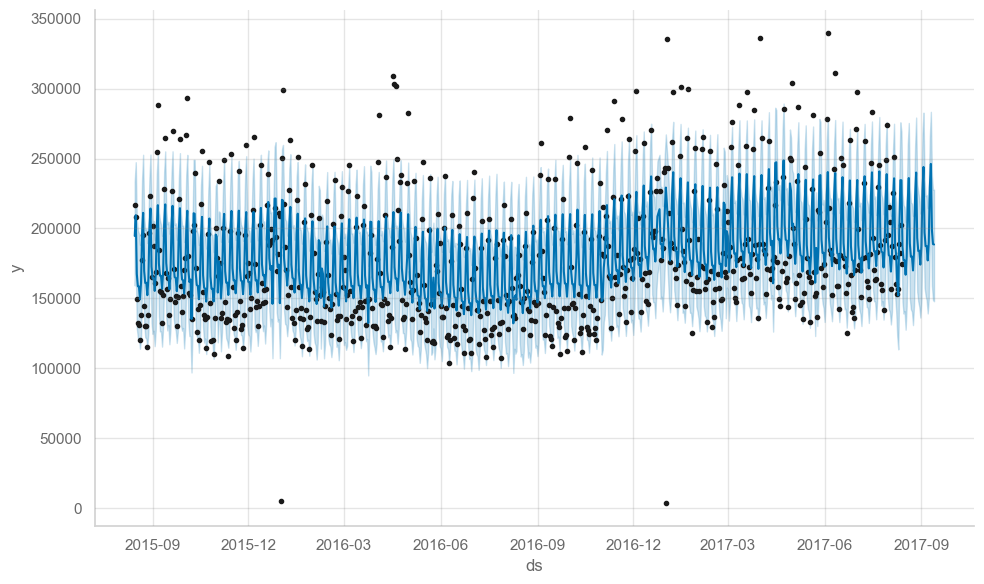

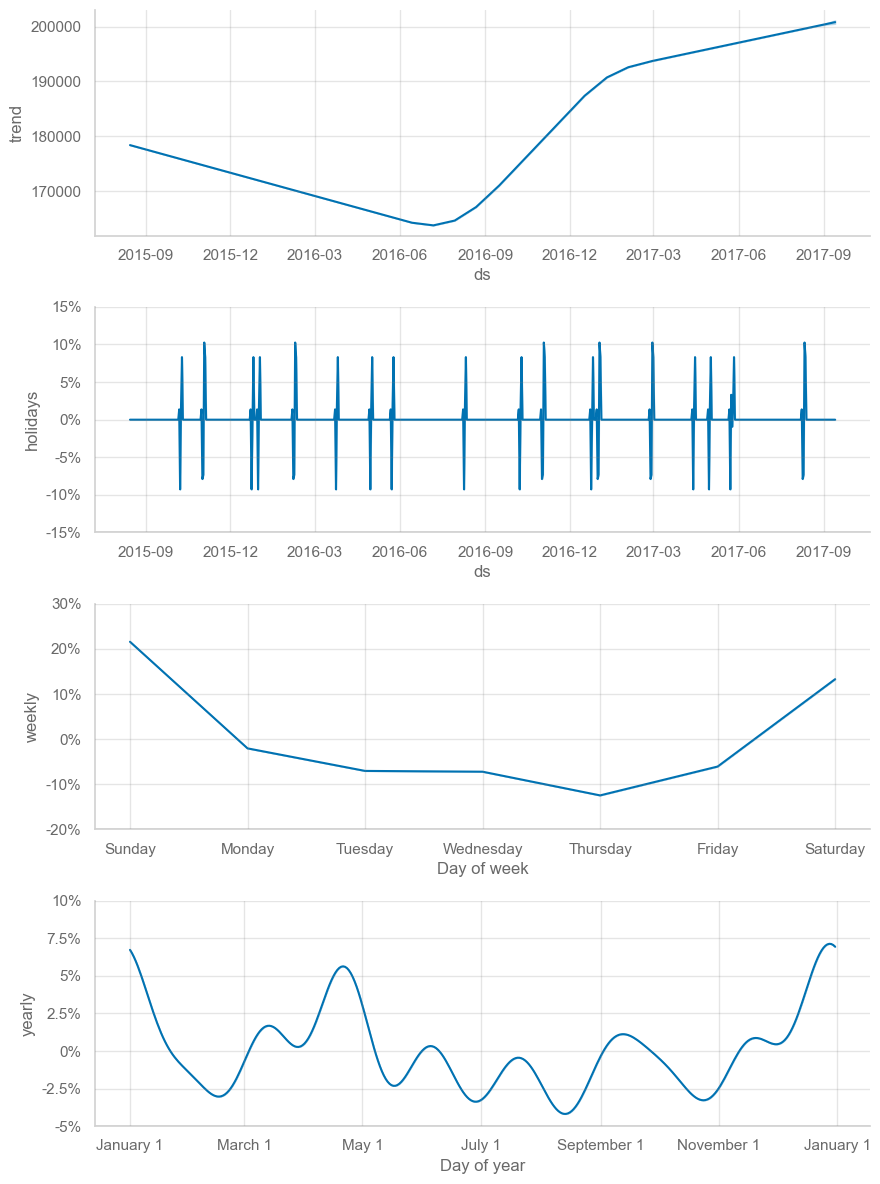

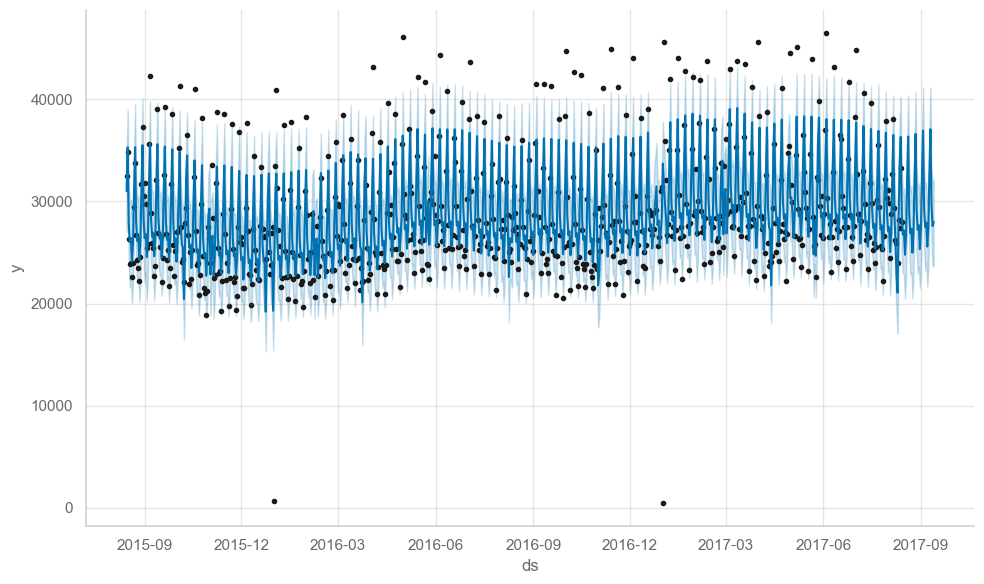

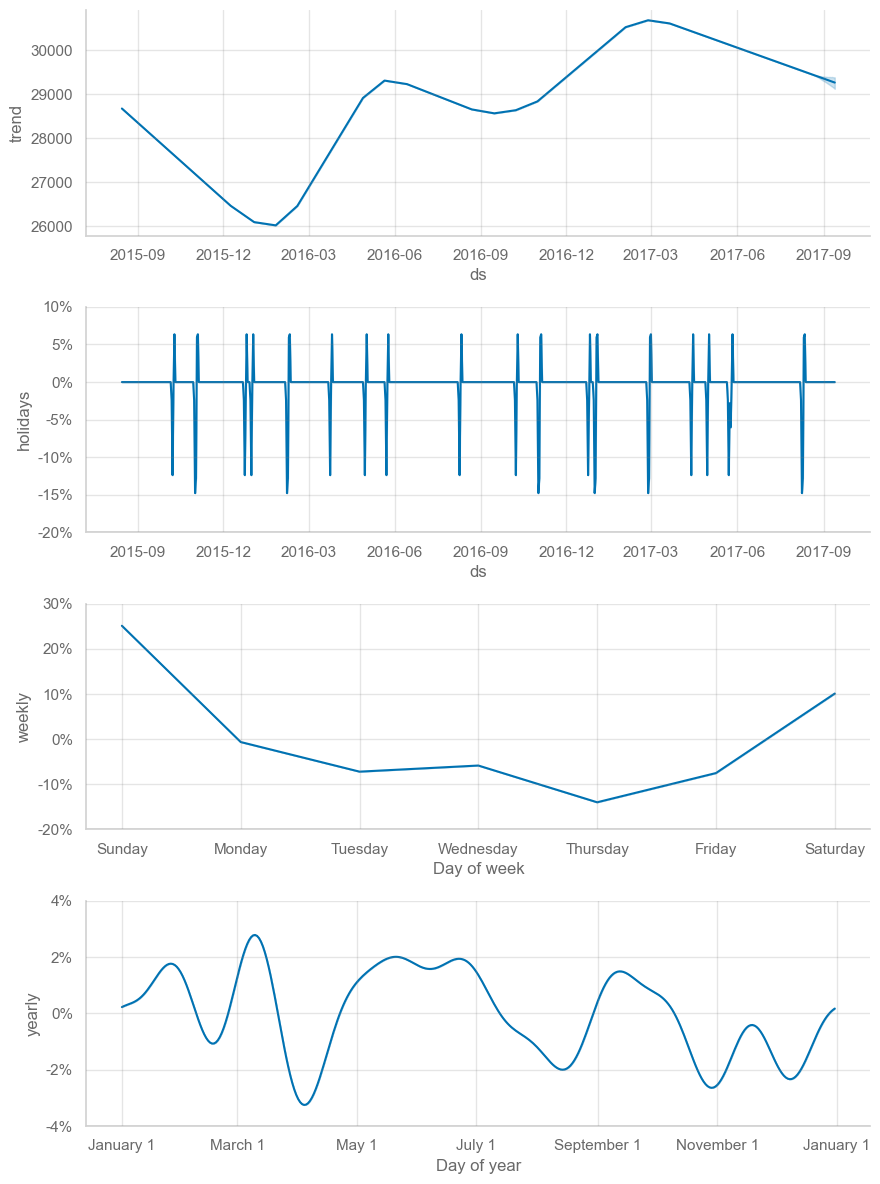

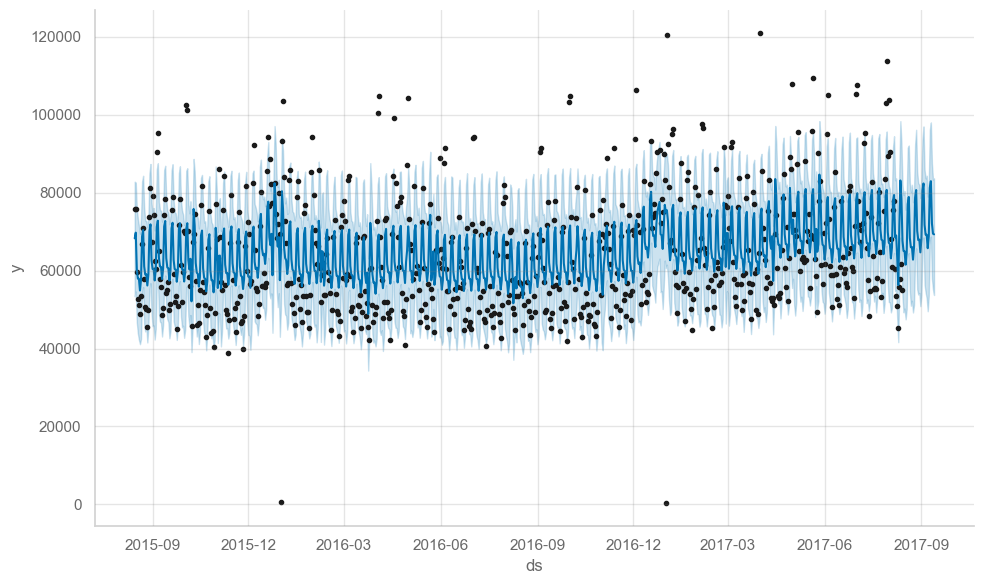

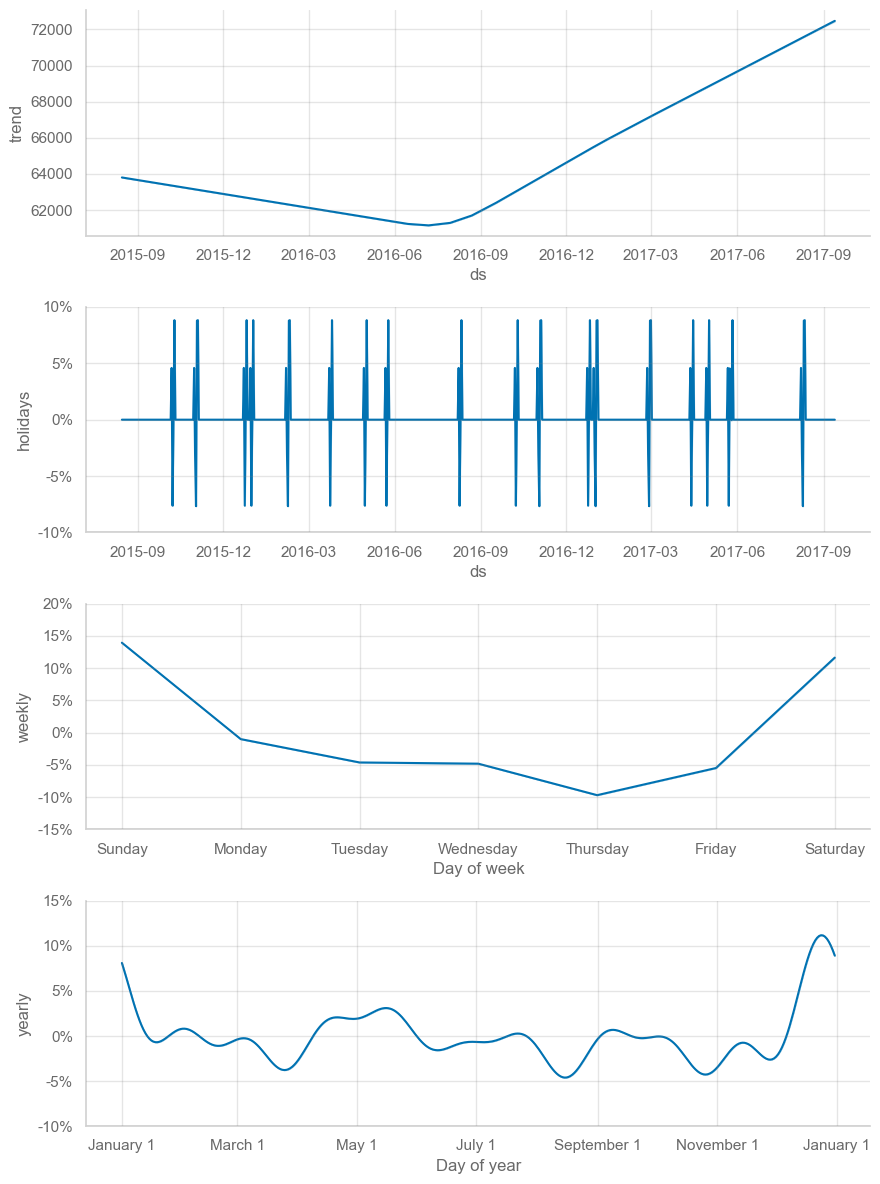

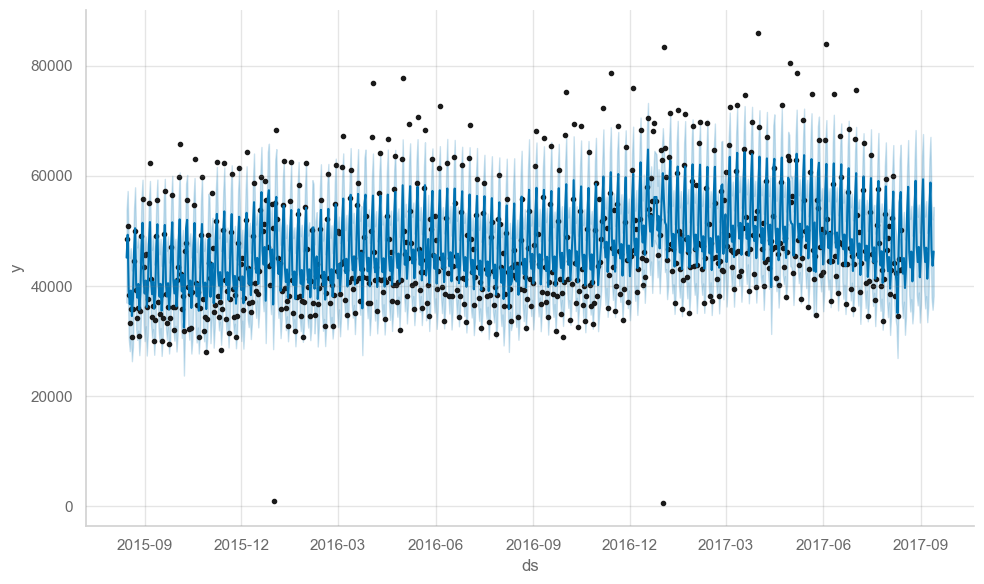

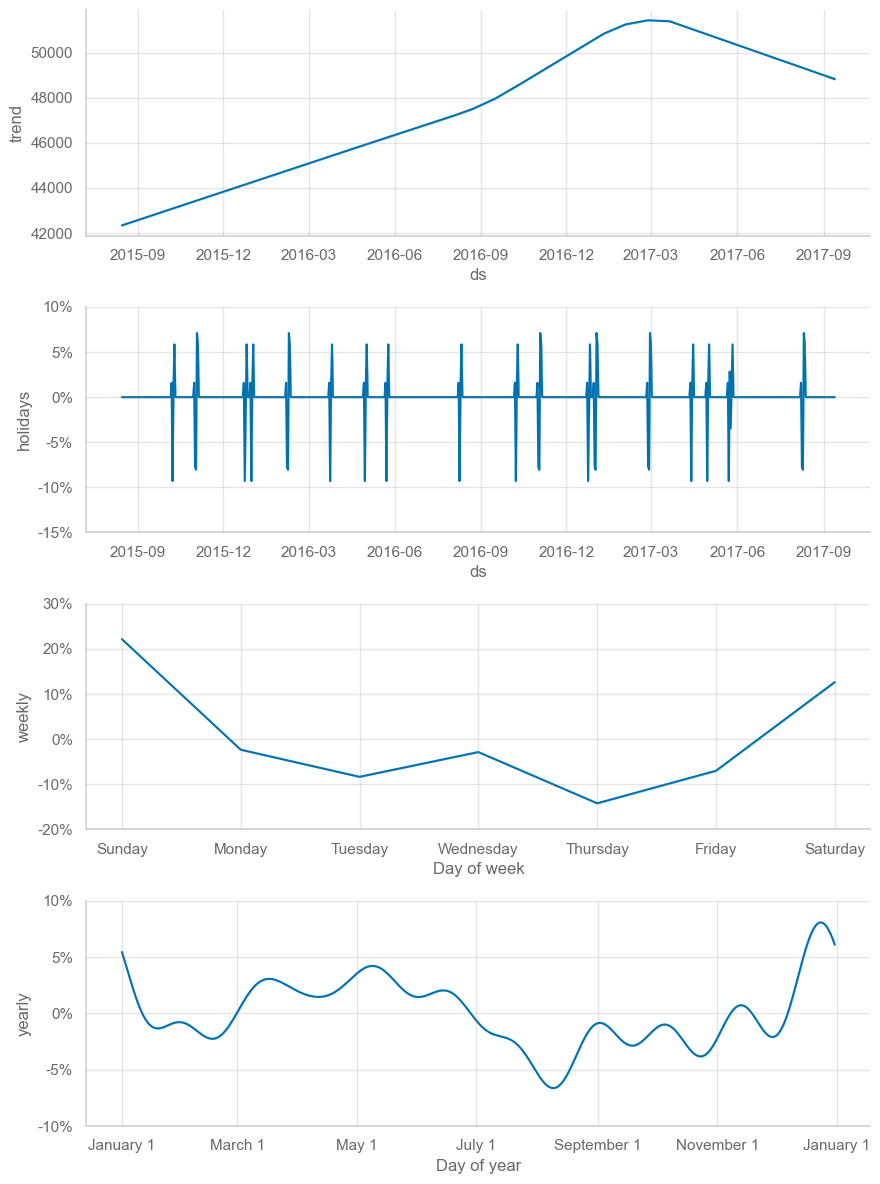

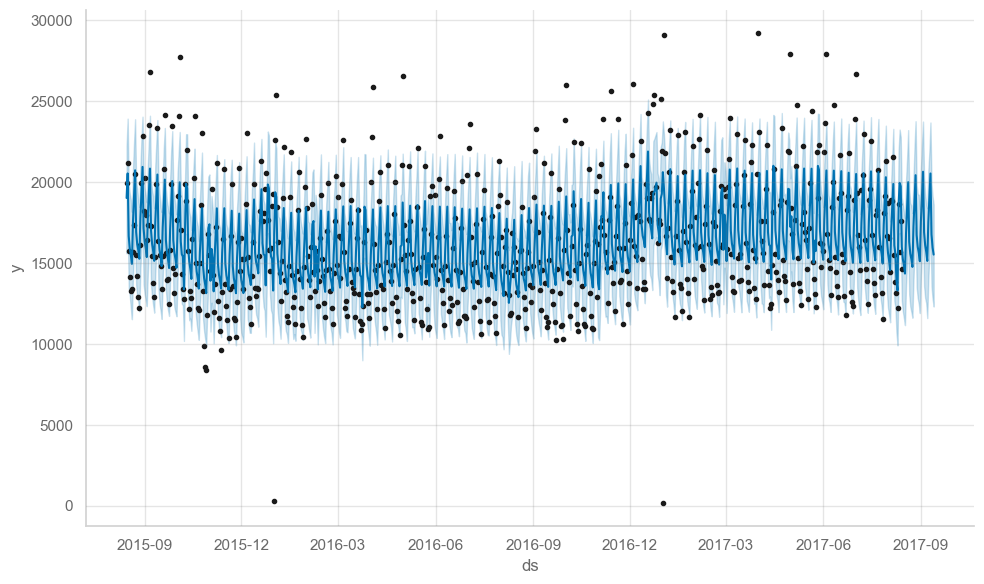

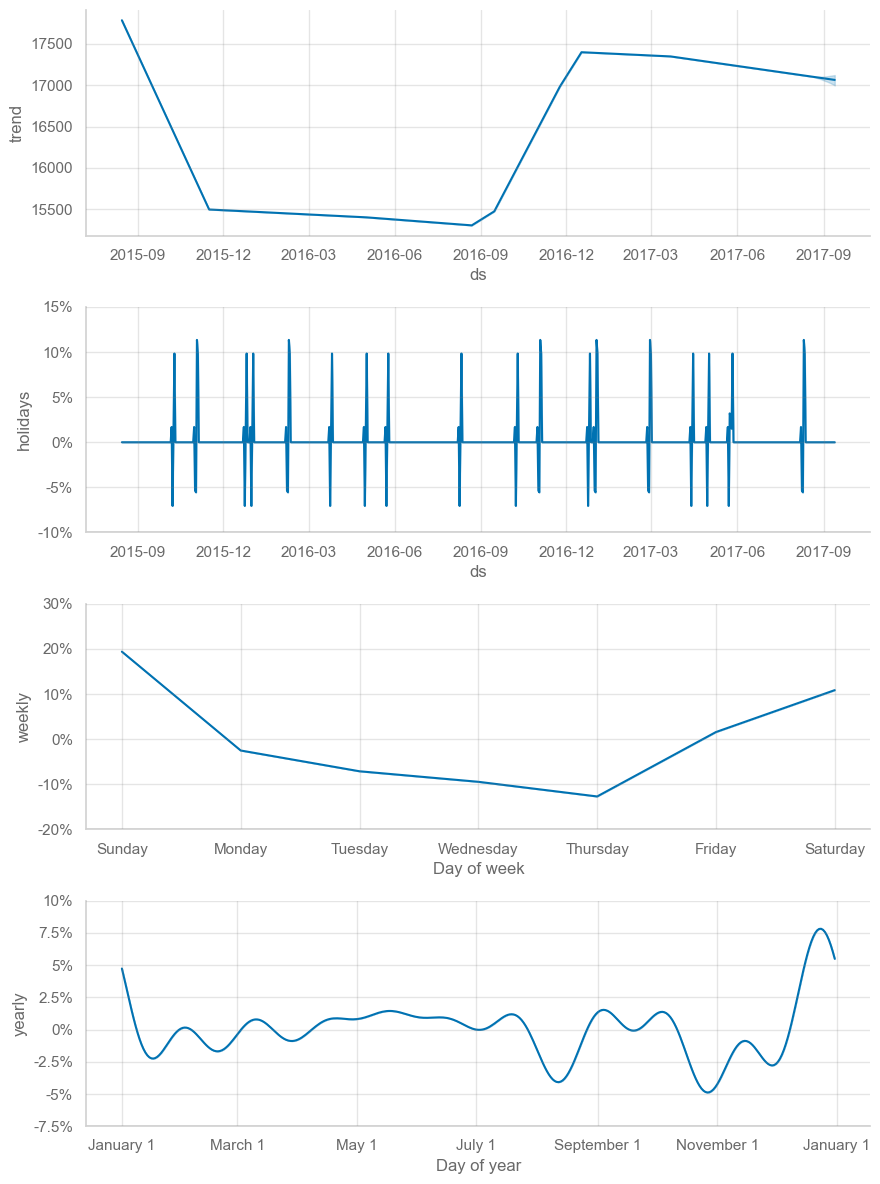

In [73]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)